## LINMA2472 - Algorithms in Data Science
# Homework 1: GAN (in fact CGAN)

Bastien Massion - bastien.massion@uclouvain.be

06 October 2024 - v2

## Guidelines
This homework is done in Python, using the PyTorch library for neural networks.

The homework is divided in 2 sections: training a CGAN and explorizing the latent space.
This Notebook contains codes to be filled-in. The goal of the homework is to use a GAN for generating handwritten numbers (and letters).
    
A big part of the code for training your CGAN is already given in this Notebook. Every part that you will have to complete is indicated in the title by a mention. When it implies to write some code, the precise location is mentioned by the line `# TO COMPLETE`. The existing code should be sufficient, but can be modified at will if it turns out to be useful for you.

Note that the proposed code gives sometimes unnecessary options for the asked tasks, but this is on purpose: this code could become an inspiration/foundation for any future CGAN project that you may have. The overlay should make the code clearer, more robust and generalisable to other possible datasets (eventually your own dataset) or tasks to offer you a better PyTorch GAN framework. Every time additional parameters should not be changed, they will be indicated by the line `# DON'T MODIFY`.

The project is done by groups of 3. Once the group is formed, register it as soon as possible in the Moodle activity "Group choice for Homework 1".

The deadline for the whole homework is: **Monday 21 October 2024, 23:59, on Moodle**.
    
Using AI writing/coding assistant (such as Chat GPT) is allowed, but you absolutely have to detail where you use it, which prompts were given and what answers you received.

Your questions or comments should be posted on the dedicated Moodle "Class forum" or kept for the Q&A session that will take place on: **Monday 7 October 2024, 08:30, in BARB91**. As a last resort, you can send them directly to the mail address: `bastien.massion@uclouvain.be`.

## Introduction
Since their introduction in 2014 by Goodfellow et al., Generative Adversarial Networks (GAN) have taken a predominant place in the deep learning landscape. GANs are deep neural networks composed of two parts: a generator and a discriminator. Those two parts are trained as opponents (hence "adversarial"): from the dataset, the generator tries to create new fake data that can fool the discriminator into thinking they are real, while the discriminator tries to distinguish between true and fake data.

Often, the most interesting part of this model is the generator, therefore we often refer to GANs as generative models. Together with diffusion models (such as Stable Diffusion or DALLE-3) for vision and with transformer models (such as GPT4) for language, these generative neural networks make up a large part of the AI world today. Experts think that we are currently living in the era of Generative AI. Lectures about some of those other topics are coming soon!

These generative properties are used in a lot of applications: mainly for image processing tasks (style transfer, segmentation, face generation, image inpainting, deblurring, super-resolution,...), but also for natural language processing tasks (text summarization, text generation,...), for music generation or even for medical tasks (tumor detection). Another major use of GANs is data augmentation, which can be successful in any data-driven sector for which collecting large annotated datasets is costly or risky (medicine, biology, psychology,...). Of course, new applications emerge and perspectives unimaginable a few years ago could soon become reality.

Conditional GAN (CGAN), introduced in 2014 by Mirza and Osindero, is a variation of the classical GAN architecture that aims to give more information to the networks to improve and control the generated outputs. In particular, the generator and the discriminator both receive the class that should be generated or discriminated.

The goal of this homework is to implement your first CGAN and explore some properties.

## Packages import
You will need several packages in order to successfully build, train and use your neural networks. In particular, we use the PyTorch framework and some of its extensions (`torchvision` and `torchinfo`) to work with neural networks.

Normally, all packages except `torchinfo` should be installed by default. However, it could be possible that some of those packages are not installed yet on the hardware you will be using for this homework. Please install them properly by following the installation guidelines in their respective documentation. If they are already installed, don't hesitate to update the packages to their most recent versions: it will run faster and safer.

The code below will automatically download the `torchinfo` package if it was not done already.

The following packages are necessary and should not be removed. However, if you want to add other packages for your figures, for timing or whatever, feel free to do so.

In [1]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn

# Torchvision is part of the PyTorch environment. It is necessary to download the datasets from EMNIST.
from torchvision.datasets import ImageFolder, EMNIST
import torchvision.transforms as t
from torch.utils.data import random_split, DataLoader

# Torchinfo is an extension of PyTorch. It is really useful for understanding the structure and the size of your models.
try:
    from torchinfo import summary
except:
    print("Installing torchinfo...")
    !pip install -q torchinfo
    from torchinfo import summary
    print("torchinfo installed successfully.")

# sklearn is another famous machine learning package which has a lot of metrics features.
from sklearn.metrics import accuracy_score

# Files management
import os

# Usual mathematical stuff
import numpy as np

# Plots
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Timing
import time
from datetime import datetime

## Resources
Training a neural network is really expensive, especially if your network is large. Moreover, training GANs is famous for its instability, as you might figure out. It is thus important to look for the most suited computing and storing resources.

In practice, parallelisation of computations can speed up the process a lot, by several orders of magnitude. In particular, computing on a GPU (Graphics Processing Unit), which has up to hundreds of cores, will be much faster than on your usual laptop CPU (Central Processing Unit), typically with less than 8 cores.

Therefore, it is useful to search for the maximum available computing power.

In this project, you are encouraged to use (external) GPU solutions. Indeed, staying on your own CPU laptop could take up to several hours for one training session... Here are some solutions to acquire such GPU.

### Your own power
If you have the chance to have your own GPU (as a gamer for example), then please use it!

The use of the CPU of your computer should be problematic for the training process of GAN, but not for the inference part. Typically, if you just want to create new images from your trained model, your CPU should be sufficient. So, the second part of the project should be doable on your CPU.

### External power: Google Colab (free)

To access more computing power, we ask you to use Google Colab: https://colab.research.google.com/.

Colab is a free and easy to use service from Google, where you can borrow their efficient resources. You only require one Google account, i.e. one Gmail adress, to use Colab and run code online.

The most common and easiest way of using Google Colab is to work with a Jupyter Notebook, so this one will perfectly do the job! Launch Colab, in files "import a new notebook" and select your Notebook for this homework. The Notebook is stored on the Google Drive associated the Gmail address, while all the related files (data, generated figures, saved models, saved latent vectors) exist in folders on the computing unit that you are connected to, and are stored in the same directory as your Notebook.

As a first step with Colab, you can use the free option. In this setting, you often have access to nice GPU's: Nvidia T4 GPU. Be aware, GPU are sometimes not available (reserved in priority for people with paying subscriptions) and there are limitations to the amount of computations that you can do in one go with the free setup ("usage limits"), so don't hesitate to start this project as quickly as possible. The whole project is doable on these T4 GPU's: it is our recommended option to make this project.

To select your resource, click on the triangle next to "Connect" in the up-right corner of your screen (see image) -> "Change runtime type" -> Select your "Hardware accelerator" -> "Save". It should then become "Connected" to the hardware you chose.

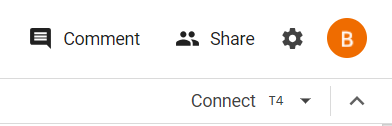
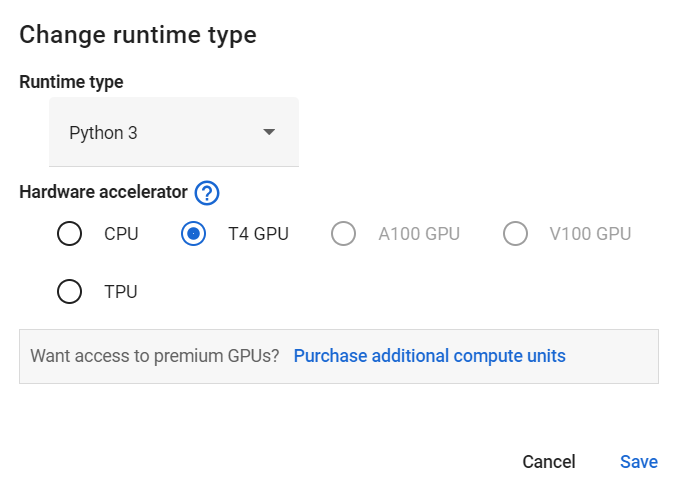

### External power: Google Colab (paying option)
However, we allow you to buy premium resource (click on "Purchase additional compute units"). In particular, we will refund one "Pay As You Go" subscription per group. It costs 11,19€ for 100 compute units, valid for 90 days. Note that you need a credit card to buy it.

For the refund procedure, you need to keep a proof of payment to Google Colab. After the deadline of this homework, an Excel file will be posted on Moodle and you will have to fill in with your refund information. Finally, you will send the Excel file and the proof of payment in one mail to Bastien Massion (bastien.massion@uclouvain.be), as soon as possible. The refund demand will then be treated.

With such compute units, you can get guaranteed access to Nvidia V100 GPU's, which work a bit better than T4 ones. If you're lucky, you could even have access to Nvidia A100 GPU's, which are amongst the best GPU's on the market.

100 compute units should allow more than 5 hours of computing. You can check your remaining total on: triangle next to "Connect" -> "View resources". However, be aware that when you possess the paying option, running with T4 GPU's will also cost you compute units...

If, despite all of this, you are not satisfied, feel free to contact Bastien Massion by mail.

### What is available?
The function `chooseDevice` automatically checks two things. First, it checks whether the run is done on Colab or on you own computer. If you are using Colab, then the source is set up as the Google Drive you are working with. Colab should ask your permission to access your Google Drive and be able to interact with it, accept it.

The second thing this function does is to check if there is a GPU available. If there is one, computations will be done there using CUDA, a parallel computing package and programming model created by NVIDIA. The code `.to(device)` is necessary to work with the GPU. It is already added where it should be, but simply be careful of adding everywhere it will be needed if you modify the rest of the code or for your further analyses. Otherwise, computations will be done by default on CPU.

The `num_workers` parameter is a bit obscure, but it roughly indicates how many units you would like to use for downloading data. It seems that 2 is fine for Colab GPU, 0 is fine for your own GPU and 0 is fine for any CPU.

There should be no need to modify the function `chooseDevice`.

In [2]:
##### Check if GPU is available

def chooseDevice():
    try:
        import google.colab
        machine = "colab"
        print("Working on Colab")

        from google.colab import drive
        source = "/content/drive/MyDrive/Colab Notebooks"
        drive.mount("/content/drive")
        print("Connected to Google Drive")
    except:
        machine = "own"
        source = "."
        print("Working on your own computer")

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
        if machine == "colab":
            num_workers = 2
        elif machine == "own":
            num_workers = 0
    else:
        device = torch.device("cpu")
        num_workers = 0
        print("GPU not available, CPU available")
    print("Number of workers:", num_workers)
    return machine, source, device, num_workers

In [3]:
machine, source, device, num_workers = chooseDevice()

Working on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Connected to Google Drive
GPU not available, CPU available
Number of workers: 0


## Files management
During this project, you will create and store new files, in particular model states, figures and latent vectors. To manage it correctly and avoid errors, we create folders to host these files before running the rest of the code.

If the source is Google Drive, then everything will be stored there: make sure that you still have room left on your drive! If the source is `'.'`, then it will be stored on your computer memory next to this Notebook.

In [4]:
source

'/content/drive/MyDrive/Colab Notebooks'

In [5]:
def createFolders(source):
    if not os.path.exists(source + '/Data'):
        os.makedirs(source + '/Data')
    if not os.path.exists(source + '/Models'):
        os.makedirs(source + '/Models')
    if not os.path.exists(source + '/Figures'):

        os.makedirs(source + '/Figures')
    print("Folders created")

In [6]:
createFolders(source)

Folders created


## Set random seed
Setting the seed for the generation of random numbers is not necessary, but can be useful for keeping consistency in your experiments.

In [7]:
seed = torch.manual_seed(2472) # DON'T MODIFY

## Datasets
Three datasets are proposed, all part of the EMNIST (Extended MNIST) dataset.

First, the **EMNIST Mnist** set, i.e. the classical MNIST set, which should only be used as proof of concept. It contains a total of 70 000 handwritten digits (60 000 train, 10 000 test) from 10 balanced classes (one for each digit).

Then, the **EMNIST Letters** set. This second dataset is larger (more data and more classes), which create more impressive results. It contains a total of 145 600 handwritten letters (124 800 train, 20 800 test) from 26 balanced classes (one for each latin letter, lowercase and uppercase mixed). It is optional, but could be used to create more impressive results.

Finally, the **EMNIST Balanced** set. This third dataset is a bit smaller but has more classes: 131 600 handwritten letters or digits (112 800 train, 18 800 test) from 47 classes (some uppercase and lowercase letters are split, some are not, and the digits). It is optional, but could be used to create more impressive results.

Every image is originally of dimension 1x28x28, which means that there is only 1 color/channel (greyscale) and that it has size 28x28 pixels (height, width).

More info on the EMNIST Dataset can be found here: https://www.kaggle.com/datasets/crawford/emnist.

### *EMNISTDataset*, *SwapAxesTransform* and *ShiftTargetTransform*

Any EMNIST (sub)dataset is imported via `torchvision`. For example, downloading the MNIST dataset returns a object of the type `torchvision.datasets.mnist.EMNIST`. It is possible to work directly with this kind of object, but we want to make the code clearer, more robust and generalisable to other possible datasets (eventually your own dataset) to offer you a better PyTorch GAN framework.

Therefore, we define another class called `EMNISTDataset`, inheriting from the more general `torchvision.datasets.ImageFolder` framework. `EMNISTDataset` could be easily modified to account for all types of image datasets (of course, this is outside of the scope of this project). The dataset imported from `torchvision.datasets.mnist.EMNIST` is then included as an attribute in the `EMNISTDataset`.

Before defining the class `EMNISTDataset`, be aware that all images in the torchvision EMNIST dataset have their axes swapped for an unknown reason. To remedy this, we first define a transform class called `SwapAxesTransform` which corrects this fault. Also, a fantom class exists in the EMNIST Letters dataset, shifting all target values by 1. The solution is `ShiftTargetTransform`.

In [8]:
class SwapAxesTransform(nn.Module):
    """Permute the x and y axes of images"""

    def __init__(self):
        super().__init__()

    def forward(self, image):
        image = torch.transpose(image,1,2)
        return image

In [9]:
class ShiftTargetTransform(nn.Module):
    """Shift targets by given value"""

    def __init__(self, shift):
        super().__init__()
        self.shift = int(shift)

    def forward(self, target):
        target += self.shift
        return target

In [10]:
##### Class for EMNISTDataset, child of torchvision.datasets.ImageFolder

class EMNISTDataset(ImageFolder):
    """EMNIST dataset"""


    def __init__(self, root=None, image_resize=(1,28,28), dataset_name="MNIST", interpolation_mode="bilinear", transform_mode="normalization", target_transform_mode="basic", number=None):
        self.dataset_name = dataset_name
        self.root = root
        self.transform = self.getTransform(image_resize, interpolation_mode, transform_mode)
        self.target_transform = self.getTargetTransform(target_transform_mode)
        self.original_dataset = self.getOriginalDataset()
        self.data, self.n_data, self.targets, self.samples, self.classes, self.n_classes, self.class_distribution = self.extractFromEMNIST()
        self.augmented_data, self.n_augmented_data = self.augmentData(number=number)


    def getTransform(self, image_resize, interpolation_mode, transform_mode):
        self.image_size = image_resize
        self.interpolation_mode = interpolation_mode
        inter_mode = self.getInterpolationMode()
        self.transform_mode = transform_mode
        n_channels, width, height = self.image_size
        if self.transform_mode == 'augmentation':
            transform = t.Compose([
                                    t.ToTensor(),
                                    SwapAxesTransform(),
                                    t.Resize((height,width), interpolation=inter_mode, antialias=True),
                                    t.RandomHorizontalFlip(),
                                    t.RandomRotation((-30,30)),
                                    t.RandomCrop((height,width), padding=(height//8,width//8)),
                                    t.ColorJitter(brightness=0.5,saturation=0.5),
                                    t.Normalize((0.5,), (0.5,))
                                  ])
        elif transform_mode == 'normalization':
            transform = t.Compose([
                                    t.ToTensor(),
                                    SwapAxesTransform(),
                                    t.Resize((height,width), interpolation=inter_mode, antialias=True),
                                    t.Normalize((0.5,), (0.5,))
                                  ])
        else:
            print("Undefined transform_mode")
        return transform


    def getInterpolationMode(self):
        if self.interpolation_mode == "bilinear":
            mode = t.InterpolationMode.BILINEAR
        elif self.interpolation_mode == "bicubic":
            mode = t.InterpolationMode.BICUBIC
        elif self.interpolation_mode == "nearest":
            mode = t.InterpolationMode.NEAREST_EXACT
        else:
            print("Undefined interpolation_mode")
        return mode


    def getTargetTransform(self, target_transform_mode):
        self.target_transform_mode = target_transform_mode
        if target_transform_mode == "basic":
            if self.dataset_name == "EMNIST_Letters":
                target_transform = ShiftTargetTransform(-1)
            else:
                target_transform = None     # No target transform mode defined yet
        else:
            print("Undefined target_transform_mode")
        return target_transform


    def getOriginalDataset(self):
        if self.dataset_name == "MNIST":
            return EMNIST(root=self.root, split="mnist", train=True, download=True, transform=self.transform, target_transform=self.target_transform)
        elif self.dataset_name == "EMNIST_Letters":
            return EMNIST(root=self.root, split="letters", train=True, download=True, transform=self.transform, target_transform=self.target_transform)
        elif self.dataset_name == "EMNIST_Balanced":
            return EMNIST(root=self.root, split="balanced", train=True, download=True, transform=self.transform, target_transform=self.target_transform)
        else:
            print("Undefined dataset")


    def extractFromEMNIST(self):
        classes = self.original_dataset.classes.copy()
        targets = self.original_dataset.targets.tolist().copy()
        if self.dataset_name == "EMNIST_Letters":
            if "N/A" in classes:
                classes.remove("N/A")
            targets = torch.tensor(targets) - 1
            targets = targets.tolist()
        samples = targets
        n_classes = len(classes)
        n_data = len(targets)
        data = []
        class_distribution = [0]*n_classes
        for idx in range(n_data):
            target = targets[idx]
            name = classes[target]
            data += [[target, name]]
            class_distribution[target] += 1

        return data, n_data, targets, samples, classes, n_classes, class_distribution


    def augmentData(self, number=None):
        if number != None and type(number) == int:
            repeats = max(number//self.n_data,1)
            augmented_data = self.data*repeats
        else:
            augmented_data = self.data
        n_augmented_data = len(augmented_data)
        return augmented_data, n_augmented_data


    def getInfos(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        identity = self.augmented_data[idx]
        number = identity[0]
        name = identity[1]
        return number, name


    def __getitem__(self, idx):
        # In practice, only one index at a time
        image = self.original_dataset.__getitem__(idx)[0]
        number = self.original_dataset.__getitem__(idx)[1]
        name = self.classes[number]
        generated = False

        dict_image = {'image': image, 'number': number, 'name': name, 'index': idx, 'generated': generated}
        return dict_image

### Import dataset ###
With the dataset defined correctly, we can now import it to work with it. We'll do it with the `getDataset` function.

The function will also split the dataset in a training and a testing set according to your preferences. You could also split it in 3 (with an additional validation set), but it will require to adapt the given code in the rest of the project.

The first time you run the `getDataset` function on a specific hardware, you will probably have to wait for some time for the whole dataset to be downloaded. This can last for 10 minutes on your CPU. But don't worry, working with it afterwards will be faster as the data loaders (see below) will immediately have access to the data.

In [11]:
##### Import dataset and its subsets (training, (validation,) testing datasets)

def getDataset(dataset_name, image_resize, interpolation_mode, transform_mode, split, number=None, info=True, source="."):

    # Import dataset
    if dataset_name == "MNIST" or dataset_name == "EMNIST_Letters" or dataset_name == "EMNIST_Balanced":
        path_data = source + '/Data'
        dataset = EMNISTDataset(root=path_data, image_resize=image_resize, dataset_name=dataset_name, interpolation_mode=interpolation_mode, transform_mode=transform_mode, number=number)

    else:
        print("DATASET NOT CORRECTLY DEFINED")

    if info:
        print(dataset)

    # Split dataset
    rng = torch.Generator().manual_seed(2472)
    if len(split) == 2:
        train_dataset, test_dataset = random_split(dataset, split, generator=rng)
        return dataset, train_dataset, test_dataset
    elif len(split) == 3:
        train_dataset, validation_dataset, test_dataset = random_split(dataset, split, generator=rng)
        return dataset, train_dataset, validation_dataset, test_dataset
    else:
        print("Split has not acceptable length")

By default, the MNIST dataset is selected. However, you can choose which dataset to download and how to download it: eventual resize of the images, transform with or without data augmentation and split proportions.

In [12]:
dataset_name = "MNIST"      # Default for this homework
#dataset_name = "EMNIST_Letters"
#dataset_name = "EMNIST_Balanced"
n_channels = 1       # DON'T MODIFY

height = 28      # DON'T MODIFY
width = 28       # DON'T MODIFY
image_resize = (n_channels,height,width)   # DON'T MODIFY
interpolation_mode = 'bilinear'    # DON'T MODIFY
transform_mode = 'normalization'   # DON'T MODIFY
split = [0.8,0.2]       # DON'T MODIFY

dataset, train_dataset, test_dataset = getDataset(dataset_name, image_resize, interpolation_mode, transform_mode, split, source=source)
print(dataset.classes)

Dataset EMNISTDataset
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/Data
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Divide dataset into batches
For training and testing of neural nerwork, it is impractical to use complete datasets. Indeed, computation and memory requirements would be unfeasible for the hardware. The solution is to divide the dataset in smaller batches, for which the process is affordable, and to iterate on each batch. Typically, the batch size is orders of magnitude smaller than the whole dataset.

The function `divideInBatches` splits the dataset into batches and creates the loaders for the data.

You can modify the value of parameter `batch_size` as you wish.

In [13]:
##### Divide dataset into subsets and batches and create loaders for each subset

def divideInBatches(train_dataset, test_dataset, batch_size, num_workers):

    # Train set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    n_batches_train = len(train_loader.batch_sampler)

    # Test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    n_batches_test = len(test_loader.batch_sampler)

    return train_loader, test_loader, n_batches_train, n_batches_test

In [14]:
batch_size = 64

k = int(2*batch_size*1.0)
# k = int(batch_size*1.0)

train_loader, test_loader, n_batches_train, n_batches_test = divideInBatches(train_dataset, test_dataset, batch_size, num_workers)

### Show samples ###

During the whole homework, it will be important to show samples, either from the dataset, either ones your generate. Here is a function to help you visualize and avoid losing any plot that you once created.

The function `plotSamples` allows to represent up to 20 images. You can specify whether they are generated by your generator or not (i.e. coming from the dataset). For the ones from the dataset, their label is showed as well.

The created figures are stored in the folder: Figures. The figures are stored with a predefined name depending on the (date)time.

You can of course modify this function as you wish.

In [15]:
##### Plotting/Showing examples from the dataset

def plotSamples(samples, epoch=None, source="."):
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    images = samples['image']
    images = t.Normalize((-1.0,), (2.0,))(images)
    names = samples['name']
    generated = samples['generated']

    if all(generated):
        if epoch!=None:
            plt.close("Epoch " + str(epoch))
            f = plt.figure("Epoch " + str(epoch), figsize = (10,7))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 20)
            save_name ='Sample_generated_' + now + '__epoch_' + str(epoch)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (10,7))
            f.suptitle("Generated samples trained model", fontsize = 20)
            save_name ='Sample_generated_' + now
    elif all(generated == False):
        plt.close("Dataset samples")
        f = plt.figure("Dataset samples", figsize = (10,7))
        f.suptitle("Dataset samples", fontsize = 20)
        save_name = "Sample_dataset"
    else: # Mix of generated samples and data from the dataset
        if epoch!=None:
            plt.close("Epoch " + str(epoch))
            f = plt.figure("Epoch " + str(epoch), figsize = (10,7))
            f.suptitle("Sample epoch " + str(epoch), fontsize = 20)
            save_name = "Sample_dataset_" + now + '__epoch_' + str(epoch)
        else:
            plt.close("Samples")
            f = plt.figure("Samples", figsize = (10,7))
            f.suptitle("Sample trained model", fontsize = 20)
            save_name = "Sample_dataset_" + now

    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)

    n = len(images)
    for i in range(np.min([20,n])):
        image = images[i]
        name = names[i]
        label = name
        if generated[i] == True:
            label += " (gen)"
        fi = f.add_subplot(4, 5, i + 1)
        image_to_plot = torch.permute(image.cpu().detach(),(1,2,0))
        color_map = None
        if image_to_plot.size()[2] == 1:
            color_map = 'gray_r' # you can change the color map if you want
        fi.imshow(image_to_plot, cmap=color_map)
        plt.xticks([])
        plt.yticks([])
        fi.title.set_text(label)

    f.savefig(source + '/Figures/' + save_name + '.png')

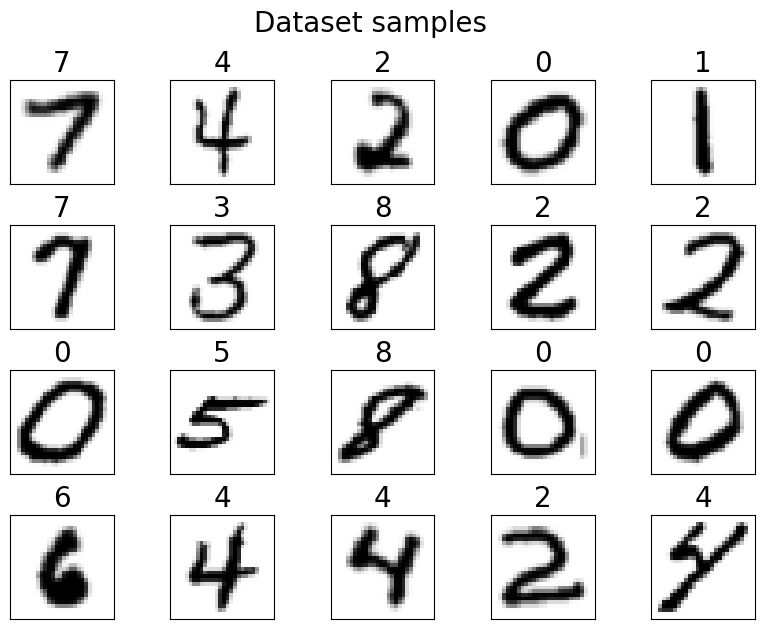

In [16]:
data_batch = next(iter(train_loader))
plotSamples(data_batch, source=source)

## Section 1: Train your GAN
In this first part, you are asked to train and test a CGAN for the generation of fake handwritten digits (and letters).

Let's just recall what training a model means in machine learning. It is in fact quite simple: given a model architecture, use an optimization scheme to minimize a loss function (representing the gap between the data and the model predictions) in order to find the optimal values of the model parameters. In this Section, all of these elements are treated one by one.

Let's maybe first recall the global architecture of the a GAN model. GANs are deep neural networks composed of two parts: a generator and a discriminator. Those two parts are trained as opponents (hence "adversarial"). On one side, the generator tries, from random latent vectors, to create new fake data that can fool the discriminator into thinking they are really coming from the dataset. Meanwhile, the discriminator tries to distinguish between true and fake data.

Conditional GAN (CGAN), introduced in 2014 by Mirza and Osindero, is a variation of the classical GAN architecture that aims to give control the generated outputs by inputting (in addition to the latent vector) a label corresponding to what should be generated. In particular, the generator and the discriminator both receive the label, i.e. the class, that should be generated or discriminated. During inference, this label can be chosen by the user, similar to prompts for LLMs like ChatGPT. The figure below illustrates the structural difference between GAN and CGAN.

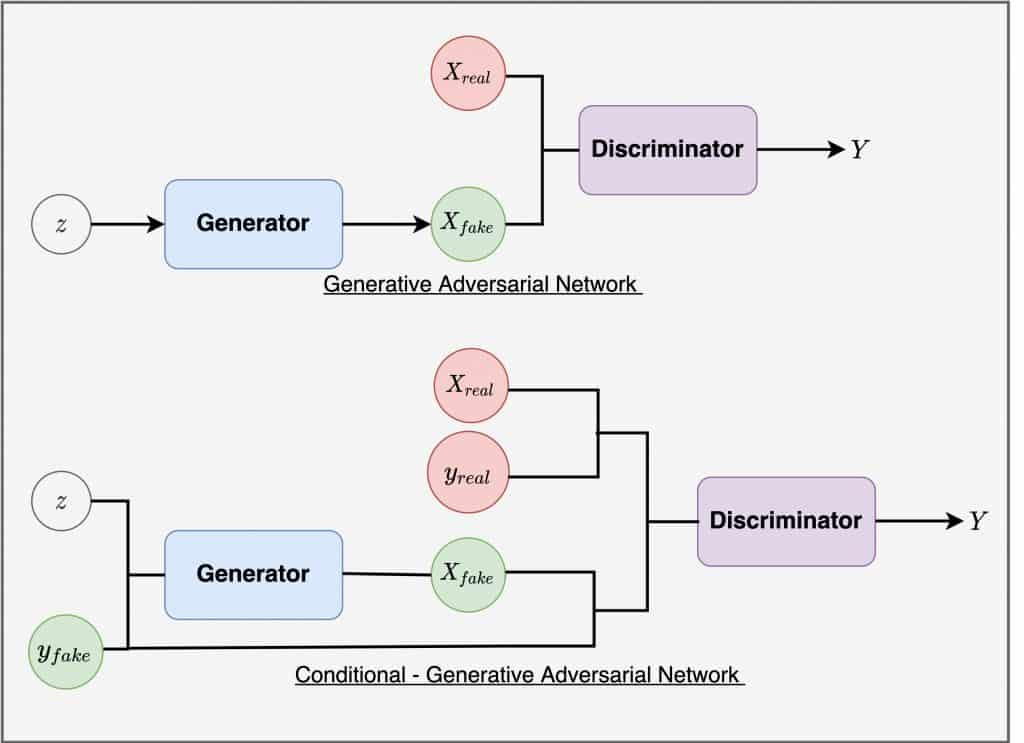

In this project, all latent vectors $z$ are sampled from a multivariate standard normal distribution in `dim_latent_space`, i.e. drawn from $N(0,I_{\text{dim_latent_space}})$.

Also, it is hard for a network to work directly with categorical data such as labels. Therefore, the label should be encoded in some way before being given to the CGAN. The most common and naive way to do this is to use is to use "one-hot encoding". The idea is to create a vector with one 1 for the class it belongs to and 0 for every other class. However, this might not be really efficient computationwise and memorywise.  The solution is to let the model find by itself an Embedding vector for each label, in an embedding space with a chosen dimension. This embedding space is continuous and learnable, which improves the encoding of the labels. In practice, the embedding is done using the `torch.nn.Embedding` layer.

### Information about architectures ###
The `getInfoModel` function uses the `torchinfo` package in order to deliver as many useful information about your model as possible. It allows you for example to know the total number of parameters in your model, or to see how many parameters compose each layer.

In [17]:
##### Infos about a model

def getInfoModel(model, batch_size, model_name=None):
    if isinstance(model.input_size, list):
        input_size = [(batch_size, ) + in_size for in_size in model.input_size]
        dtypes = [in_type for in_type in model.input_type]
    else:
        input_size = (batch_size, ) + model.input_size
        dtypes = model.input_type
    print(input_size)
    model_summary = summary(model, input_size=input_size, dtypes=dtypes, verbose=0,
                            col_names=["input_size","output_size","num_params","kernel_size"])
    if model_name != None:
        print("Model: " + model_name)
    print(model_summary)
    return model_summary

### Architectures
You receive a basic / reference *Generator* and *Discriminator* architectures. You can change these neural network architectures if you want: you can add or remove layers, you can change their width, yo can modify the kernels, you can add connections, you can change the type of layers, you can change the activation functions, ... Whatever you like the most!


### 1.1a Discriminator class

The Discriminitor takes a batch of 1x28x28 pixels images and a batch of labels associated with the images as input, and ouputs numbers between -inf and +inf (`forward()`). The activation of the last layer represents some likelihood of the image being real or not, according to the model. Afterwards, it goes through a sigmoid function in order to scale numbers between 0 and 1 (`scalingOutputs()`) such that they look like probabilities. An output of 0.0 means that the model is certain that the corresponding input image is fake, and an output of 1.0 means that it is certain input is real.

Notice that the `forward(x,y)` function of the discriminator, which is called when doing a "forward pass" through the discriminator, receives two inputs: an image $x$ and label indication $y$. Most of the time, $y$ will be an integer (i.e. the label), but we also allow it to be a floating point label embedding vector. This will be useful for interpolation between labels later in the homework.

The function `embeddingToLabel()` performs a 1-NN (nearest neighbour) classification for embedding vectors which do not correspond directly to a label.

You cannot change any method definition (nor its name nor its arguments) and all methods should be completed.

In [18]:
class Discriminator(nn.Module):

    def __init__(self, dim_label_encoding, classes, ndf, image_resize, threshold=0.5):
        self.dim_label_encoding = dim_label_encoding
        self.classes = classes
        self.n_classes = len(self.classes)
        self.ndf = ndf      # Depth of feature maps in the first layer of the discriminator
        self.n_channels = image_resize[0]
        self.height = image_resize[1]
        self.width = image_resize[2]
        self.input_size = [image_resize, ()]      # empty/contracted dimension (because only one element per datapoint)
        self.input_type = [torch.float, torch.int]
        self.output_size = ()
        self.output_type = torch.float
        self.threshold = threshold

        super().__init__()

        if self.height%4 != 0 or self.width%4 != 0:
            print("Dimension problems coming")

        self.emb0 = nn.Embedding(self.n_classes, self.dim_label_encoding)
        self.lin0 = nn.Linear(self.dim_label_encoding, 1*self.height*self.width)

        self.conv1 = nn.Conv2d(self.n_channels+1, self.ndf, kernel_size = 3, stride = 2, padding = 1)
        self.lrelu1 = nn.LeakyReLU(0.2)
        self.drop1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(self.ndf, self.ndf*2, kernel_size = 3, stride = 1, padding = 1)
        self.lrelu2 = nn.LeakyReLU(0.2)
        self.drop2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(self.ndf*2, self.ndf*4, kernel_size = 3, stride = 1, padding = 1)
        self.lrelu3 = nn.LeakyReLU(0.2)
        self.drop3 = nn.Dropout2d(0.25)
        self.conv4 = nn.Conv2d(self.ndf*4, self.ndf*4, kernel_size = 3, stride = 2, padding = 1)
        self.lrelu4 = nn.LeakyReLU(0.2)
        self.drop4 = nn.Dropout2d(0.25)
        self.lin5 = nn.Linear((self.ndf*4)*(self.height//4)*(self.width//4), 1)

    def scalingOutputs(self, x):
        scaled_outputs = torch.sigmoid(x)
        return scaled_outputs

    def predict(self, x, threshold=None):
        if threshold == None:
            threshold = self.threshold
        x_scaled = self.scalingOutputs(x)
        x_predicted = torch.where(x_scaled > threshold, 1.0, 0.0)
        return x_predicted

    def labelToEmbedding(self, label):
        emb = self.emb0(label)
        return emb

    def embeddingToLabel(self, emb, device):
        emb_classes = self.emb0(generateLabelVectors(self.n_classes, self.n_classes, label_type="range", device=device))
        labels = torch.argmin(torch.cdist(emb, emb_classes), axis=1)
        return labels

    def forward(self, x, y):
        if y.dtype in [torch.int, torch.int32, torch.int64]:   # y is a label
            emb = self.labelToEmbedding(y)
        else:    # y is an embedding
            emb = y
        emb = self.lin0(emb)
        emb = emb.view(-1, 1, self.height, self.width)

        x = torch.cat([x, emb], 1)
        x = self.conv1(x)
        x = self.lrelu1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.lrelu2(x)
        x = self.drop2(x)
        x = self.conv3(x)
        x = self.lrelu3(x)
        x = self.drop3(x)
        x = self.conv4(x)
        x = self.lrelu4(x)
        x = self.drop4(x)
        x = x.view(-1, (self.ndf*4)*(self.height//4)*(self.width//4))
        x = self.lin5(x)
        x = x.view(-1)
        return x

### 1.1b Generator class
The Generator class takes a batch of latent vectors and a batch of labels as inputs. Indeed, the generator will create an image (1x28x28) from each input latent vector (1 color i.e. gray-scale, 28x28 pixels) and each desired label. The latents vectors are of dimension dim_latent_space with each entry sampled from a standard normal distribution $N(0,1)$.

The latent space is thus a space where the information contained in the images is compressed/condensed. This latent space will be the focus of the second part of the homework.

Similarly to the discriminator, the generator `forward(z,y)` function receives a latent vector $z$ and a $y$ which can be either an integer label or floating point label embedding vector (in which case you skip the embedding module).

The function `embeddingToLabel()` performs a 1-NN (nearest neighbour) classification for embedding vectors which do not correspond directly to a label.

You cannot change any method definition (nor its name nor its arguments) and all methods should be completed.

In [19]:
##### Define a class for a Generator neural network

class Generator(nn.Module):

    def __init__(self, dim_latent_space, dim_label_encoding, classes, ngf, image_resize):
        self.dim_latent_space = dim_latent_space
        self.dim_label_encoding = dim_label_encoding
        self.classes = classes
        self.n_classes = len(self.classes)
        self.ngf = ngf      # Depth of feature maps in the last layer of the generator
        self.n_channels = image_resize[0]
        self.height = image_resize[1]
        self.width = image_resize[2]
        self.input_size = [(self.dim_latent_space, ), ()]    # empty dimension
        self.input_type = [torch.float, torch.int]
        self.output_size = image_resize
        self.output_type = torch.float

        super().__init__()

        if self.height%4 != 0 or self.width%4 != 0:
            print("Dimension problems coming")

        self.emb0 = nn.Embedding(self.n_classes, self.dim_label_encoding)

        self.lin1 = nn.Linear(self.dim_latent_space+self.dim_label_encoding, (self.ngf*4)*(self.height//4)*(self.width//4))
        self.batch_norm1 = nn.BatchNorm2d(self.ngf*4)
        self.relu1 = nn.ReLU()
        self.trans_conv2 = nn.ConvTranspose2d(self.ngf*4, self.ngf*4, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(self.ngf*4)
        self.relu2 = nn.ReLU()
        self.trans_conv3 = nn.ConvTranspose2d(self.ngf*4, self.ngf*2, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(self.ngf*2)
        self.relu3 = nn.ReLU()
        self.trans_conv4 = nn.ConvTranspose2d(self.ngf*2, self.ngf, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm4 = nn.BatchNorm2d(self.ngf)
        self.relu4 = nn.ReLU()
        self.trans_conv5 = nn.ConvTranspose2d(self.ngf, self.n_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.tanh5 = nn.Tanh()

    def labelToEmbedding(self, label):
        emb = self.emb0(label)
        return emb

    def embeddingToLabel(self, emb, device):
        emb_classes = self.emb0(generateLabelVectors(self.n_classes, self.n_classes, label_type="range", device=device))
        labels = torch.argmin(torch.cdist(emb, emb_classes), axis=1)
        return labels

    def forward(self, z, y, device=None):
        batch_size = len(z)
        x = z.clone()

        if y.dtype in [torch.int, torch.int32, torch.int64] and device == None:    # y is a label, device not precised
            labels = y.clone()
            emb = self.labelToEmbedding(labels)
        elif device != None:     # y is an embedding, device precised
            emb = y.clone()
            labels = self.embeddingToLabel(emb, device)

        names = [self.classes[label] for label in labels.tolist()]
        emb = emb.view(-1, self.dim_label_encoding)

        x = torch.cat([x, emb], 1)
        x = self.lin1(x)
        x = x.view(-1, self.ngf*4, self.height//4, self.width//4)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.trans_conv2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.trans_conv3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.trans_conv4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.trans_conv5(x)
        x = self.tanh5(x)

        dict_image = {'image': x, 'latent_vector': z, 'label_embedding': emb, 'number': labels, 'name': names, 'generated': [True]*batch_size}
        return dict_image

Here are some important parameters for the definition the reference architecture. First of all, the dimension of the label embedding space. Then, the dimension of the latent space for the generator. Finally, the depths of the features of the first (resp. last) layer of the Discriminator (resp. Generator), which basically dictate the size of the networks.

In [20]:
##### Define your GAN model (Discriminator+Generator)

dim_label_encoding = dataset.n_classes//3
ndf = 32
dim_latent_space = 50
ngf = 16

discriminator = Discriminator(dim_label_encoding, dataset.classes, ndf, image_resize).to(device)
generator = Generator(dim_latent_space, dim_label_encoding, dataset.classes, ngf, image_resize).to(device)

In [21]:
##### Information about the models

discriminator_info = getInfoModel(discriminator, batch_size, model_name = "discriminator")
generator_info = getInfoModel(generator, batch_size, model_name = "generator")

[(64, 1, 28, 28), (64,)]
Model: discriminator
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
Discriminator                            [64, 1, 28, 28]           [64]                      --                        --
├─Embedding: 1-1                         [64]                      [64, 3]                   30                        --
├─Linear: 1-2                            [64, 3]                   [64, 784]                 3,136                     --
├─Conv2d: 1-3                            [64, 2, 28, 28]           [64, 32, 14, 14]          608                       [3, 3]
├─LeakyReLU: 1-4                         [64, 32, 14, 14]          [64, 32, 14, 14]          --                        --
├─Dropout2d: 1-5                         [64, 32, 14, 14]          [64, 32, 14, 14]          --                        --
├─Conv2d: 1-6                            [64, 32, 14, 14]          [64, 64, 14, 14]   

### Loss functions

The loss function measures how good the model is. For the discriminator, it a binary classification problem: the discriminator tries to distinguish true data (label = 1) from fake generated ones (label = 0). Therefore, we use a Binary Cross Entropy loss. As the only goal of the generator is to fool the discriminator, it can also be expressed with a Binary Cross Entropy loss function. The generator wins when the discriminator classified generated data as true (label = 1) and and true data as faked (label = 0)

You see that `BCELoss` is replaced by `BCEWithLogitsLoss` for training stability issues. This implies that the output of the discriminator forward pass is not scaled to `[0.0,1.0]`, i.e. there is no sigmoid scaling last layer of any Discriminator architecture.

This loss function should **not** be changed.

In [22]:
# Loss function for the GAN

#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.BCEWithLogitsLoss()     # DON'T MODIFY

Let's also enable printing of the loss at a given epoch.

In [23]:
def printGANLoss(loss_discriminator, loss_generator, epoch):
    print("Epoch %d: Mean Loss Discriminator: %.3f" %(epoch, np.mean(loss_discriminator[epoch])))
    print("Epoch %d: Mean Loss Generator: %.3f" %(epoch, np.mean(loss_generator[epoch])))

### Optimizers
In machine learning and neural networks training in particular, adaptive stochastic gradient descent algorithm are used and have seen an impressive amount of development over the last 10 years. For your information, those types of optimization algorithms are variants on the famous gradient descent (first order algorithms). On the one hand, the stochasticity (randomness) comes from the fact that we compute the gradient only on one batch at a time, which is a random selection of few data points within the whole dataset. This randomness allows for more robustness against local minima, which is a positive side effect of using batches for training. On the other hand, the adaptivity means that the stepsize is adapted at each iteration using acceleration techniques, giving faster convergence.

Within those algorithms, Adam is the most famous and massively used one. You can play around with the Adam parameters if you want.

You are free to try other algorithms for training, for example AdamW which is a variant of Adam compatible with weight decay ($L_2$ regularization), another popular technique to improve the quality of results in learning problems.

In [24]:
##### Optimizers

lr_discriminator = 0.0002
betas_discriminator = (0.5, 0.999)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=betas_discriminator)

lr_generator = 0.0002
betas_generator = (0.5, 0.999)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator, betas=betas_generator)

# weight_decay_discriminator = 0.01
# optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=lr_discriminator, betas=betas_discriminator, weight_decay=weight_decay_discriminator)
# optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=lr_generator, betas=betas_generator, weight_decay=weight_decay_generator)

### Metrics: accuracy (of the discriminator) and timing
    
We define one error measure as the accuracy reached by the discriminator for its predictions `y_predicted`, i.e. the ratio between the number of correct classifications and the total number of samples.

During the training, data are loaded batch by batch. It could thus be a good idea to consider that the inputs of the following function are the true and predicted labels from one batch of data. The following method also compute the accuracy of you model on the true data and on the generated/fake data separately.

In [25]:
def computeGANAccuracy(y_predicted, y_official, threshold=0.5):
    y_predicted = y_predicted.cpu().detach().numpy()
    y_official = y_official.cpu().detach().numpy()
    ind_real = np.argwhere(y_official==1)
    ind_fake = np.argwhere(y_official==0)
    accuracy = accuracy_score(y_official, y_predicted)
    accuracy_real = accuracy_score(y_official[ind_real], y_predicted[ind_real])
    accuracy_fake = accuracy_score(y_official[ind_fake], y_predicted[ind_fake])
    return [accuracy,accuracy_real,accuracy_fake]

Let's also enable printing of the loss at a given epoch.

In [26]:
def printGANAccuracy(accuracy_train, accuracy_test, epoch):
    print("Epoch %d: Mean Discriminator Training Accuracy: %.3f (global), %.3f (real), %.3f (fake)" %(epoch, np.mean(accuracy_train[epoch,:,0]),np.mean(accuracy_train[epoch,:,1]),np.mean(accuracy_train[epoch,:,2])))
    print("Epoch %d: Mean Discriminator Testing Accuracy: %.3f (global), %.3f (real), %.3f (fake)" %(epoch, np.mean(accuracy_test[epoch,:,0]),np.mean(accuracy_test[epoch,:,1]),np.mean(accuracy_test[epoch,:,2])))

Another widely used metrics is the training time. Timing is done in the training process below with the famous `time` package. Here is a simple function to help you print your timings.

In [27]:
def computeAndPrintTime(title, epoch, start_time, end_time):
    delta_time = end_time - start_time
    hours = delta_time // 3600
    minutes = (delta_time - hours*3600) // 60
    seconds = delta_time - hours*3600 - minutes*60
    print(title, "%d: %d h %d min %.1f sec" %(epoch, hours, minutes, seconds))
    return delta_time

### Create data to feed the networks

As we are in Conditional GAN settings, both networks require labels corresponding to the classes of the images we would like to generate or to discriminate.


In [25]:
def generateLabelVectors(n_vectors, n_classes, labels=None, label_type="range", device="cpu"):
    if isinstance(labels, list) and label_type == "given":
        labels = torch.tensor(labels)
    elif isinstance(labels, int) and label_type == "same":
        labels = torch.ones((n_vectors,), dtype=torch.int)*labels
    elif labels == None and label_type == "range":
        labels = torch.arange(n_vectors) % n_classes
    elif labels == None and label_type == "random":
        labels = torch.randint(n_classes, (n_vectors,))
    else:
        print("Undefined label_type")
    labels = labels.to(device)
    return labels

All latent vectors $z$ are sampled from a multivariate standard normal distribution in `dim_latent_space`, i.e. drawn from $N(0,I_{\text{dim_latent_space}})$.

In [26]:
def generateLatentVectors(n_vectors, dim_latent_space, scaling=1.0, device="cpu"):
    z = torch.randn((n_vectors, dim_latent_space)).to(device)*scaling
    return z

For their training, both your generator and your discriminator need to receive inputs that they can handle. These inputs can either be extracted for the dataset (for the discriminator), either created (for the generator and for the discriminator).

While training the discriminator, fake/generated images are labelled as 0 and true images as 1, to work with the usual BCE loss for classification. On the contrary, while training the generator, fake/generated images are labelled as 1 and true images as 0, so that the generator wins when the discriminator fails.

In [27]:
def createGeneratorData(batch_size, dim_latent_space, n_classes, device, labels=None, label_type="random", training='generator'):
    latent_space_samples = generateLatentVectors(batch_size, dim_latent_space, device=device)
    generated_samples_numbers = generateLabelVectors(batch_size, n_classes, labels=labels, label_type="random", device=device)

    if training == 'generator':
        # Generator tries to fool discriminator: all generated samples are fake (0), but generator wins when discriminator thinks it's real (1)
        generated_samples_labels = torch.ones((batch_size, )).to(device)   # Fake/generated labels are 1
    elif training == 'discriminator':
        # Discriminator tries distinguish all fake generated samples (0) from real data (1)
        generated_samples_labels = torch.zeros((batch_size, )).to(device)   # Fake/generated labels are 0

    return latent_space_samples, generated_samples_numbers, generated_samples_labels

In [28]:
def createDiscriminatorData(data, generator, dim_latent_space, device, shuffle = False):
    real_samples = data['image']
    real_samples_numbers = data['number']
    batch_size = real_samples.__len__()

    real_samples = real_samples.to(device)
    real_samples_labels = torch.ones((batch_size, )).to(device)         # Real labels are 1
    real_samples_numbers = real_samples_numbers.to(device)

    latent_space_samples, generated_samples_numbers, generated_samples_labels = createGeneratorData(batch_size, dim_latent_space, generator.n_classes, device, training='discriminator')
    generated_samples = generator(latent_space_samples, generated_samples_numbers)

    all_samples = torch.cat((real_samples, generated_samples['image']))
    all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
    all_samples_numbers = torch.cat((real_samples_numbers, generated_samples_numbers))

    if shuffle:
        perm = torch.randperm(batch_size*2)
        all_samples = all_samples[perm]
        all_samples_labels = all_samples_labels[perm]
        all_samples_numbers = all_samples_numbers[perm]

    return all_samples, all_samples_labels, all_samples_numbers

### Preparing the training process
In this part, you are asked to initialize the training process (not the model which is initialized automatically).

Let's just first define the number of iterations (epochs) that the training will last. Satisfactory results can be obtained with 10 epochs, but you can of course increase this value for a longer training.
    
It turns out in practice that the generator is often harder to train than the discriminator. Therefore, we propose you another parameter which allows to train the generator on more batches than the discriminator: the discriminator will only see a proportion of 1/generator_advantage of the batches. Note that the parameter has to be greater or equal to 1. Sometimes, the discriminator could be harder to train, therefore we also define a discriminator_advantage parameter.

In [29]:
##### Training parameters

num_epochs = 25
generator_advantage = 1.0       # >= 1.0
discriminator_advantage = 1.0   # >= 1.0

It is important to keep track of the evolution of the error metrics during the training process. A simple idea is to store the values of the metrics in arrays, at least after every epoch.

In [30]:
loss_discriminator = np.zeros((num_epochs+1, n_batches_train))
loss_generator = np.zeros((num_epochs+1, n_batches_train))
accuracy_train = np.zeros((num_epochs+1, n_batches_train, 3))
accuracy_test = np.zeros((num_epochs+1, n_batches_test, 3))

It is a good option to keep track of the evolution of the images generated through the training. Defining a reference sample of latent vectors allows to generate the image for the same inputs every time. You can compute the output from those vectors after each epoch to see how the generated images evolve with the training. The latent vectors are generated from a standard normal distribution.

In [31]:
# Reference latent vectors

reference_latent_space_samples = generateLatentVectors(batch_size, dim_latent_space, device=device)
reference_number_samples = generateLabelVectors(batch_size, dataset.n_classes, label_type="range", device=device)

### Evaluation at initialization

We want to determine the performances of the model before the training. Now, to measure how (badly) our model performs at initialization by computing the loss of the generator, the loss of the discriminator and the accuracy of the discriminator. We can also visually assess the quality of the image generated by the generator by showing the images for the reference latent vectors.

In [35]:
##### Initial values of loss and accuracy

epoch = 0
print("EPOCH", epoch)

discriminator.eval()
generator.eval()

for batch, data in enumerate(train_loader):
    all_samples, all_samples_labels, all_samples_numbers = createDiscriminatorData(data, generator, dim_latent_space, device)
    output_discriminator = discriminator(all_samples, all_samples_numbers)
    loss_discriminator[epoch,batch] = loss_function(output_discriminator, all_samples_labels)
    predictions = discriminator.predict(output_discriminator)
    accuracy_train[epoch, batch] = computeGANAccuracy(predictions, all_samples_labels)

    latent_space_samples, generated_samples_numbers, generated_samples_labels = createGeneratorData(batch_size, dim_latent_space, generator.n_classes, device, training='generator')
    generated_samples = generator(latent_space_samples, generated_samples_numbers)
    output_discriminator_generated = discriminator(generated_samples['image'], generated_samples_numbers)
    loss_generator[epoch,batch] = loss_function(output_discriminator_generated, generated_samples_labels)

for batch, data in enumerate(test_loader):
    all_samples, all_samples_labels, all_samples_numbers = createDiscriminatorData(data, generator, dim_latent_space, device)
    output_discriminator = discriminator(all_samples, all_samples_numbers)
    predictions = discriminator.predict(output_discriminator)
    accuracy_test[epoch, batch] = computeGANAccuracy(predictions, all_samples_labels)

printGANLoss(loss_discriminator, loss_generator, epoch)
printGANAccuracy(accuracy_train, accuracy_test, epoch)

##### Show reference sample
generated_samples = generator(reference_latent_space_samples, reference_number_samples)
plotSamples(generated_samples, epoch=epoch, source=source)

EPOCH 0


KeyboardInterrupt: 

### 1.b Training and testing the GAN

This is finally the core part of this section: training your CGAN.

The training will follow an easy structure. Here is the basic pseudo-code of the training process of a GAN:

```
    for each epoch:

        for each batch:

            train the discriminator on the batch:

                generate fake data

                predict if data from the batch and generated data are fake or not

                compute the discriminator loss function

                backpropagate the error in the discriminator

            train the generator on the batch:

                generate fake data

                predict if generated data are fake or not

                compute the generator loss function

                backpropagate the error in the generator

        end

    end
```
    
Several improvements are already proposed in the implementation below, such as best "top-k training" [Sinha et al, 2020] and changing the schedule of number of generator and discriminator updates.

Training starts
EPOCH 1
Epoch 1: Mean Loss Discriminator: 0.178
Epoch 1: Mean Loss Generator: 5.490
Epoch 1: Mean Discriminator Training Accuracy: 0.932 (global), 0.928 (real), 0.937 (fake)
Epoch 1: Mean Discriminator Testing Accuracy: 0.874 (global), 0.748 (real), 1.000 (fake)
Time epoch 1: 0 h 0 min 40.9 sec
EPOCH 2
Epoch 2: Mean Loss Discriminator: 0.544
Epoch 2: Mean Loss Generator: 2.016
Epoch 2: Mean Discriminator Training Accuracy: 0.726 (global), 0.704 (real), 0.749 (fake)
Epoch 2: Mean Discriminator Testing Accuracy: 0.586 (global), 0.174 (real), 0.998 (fake)
Time epoch 2: 0 h 0 min 42.5 sec
EPOCH 3
Epoch 3: Mean Loss Discriminator: 0.594
Epoch 3: Mean Loss Generator: 1.385
Epoch 3: Mean Discriminator Training Accuracy: 0.680 (global), 0.653 (real), 0.708 (fake)
Epoch 3: Mean Discriminator Testing Accuracy: 0.664 (global), 0.422 (real), 0.907 (fake)
Time epoch 3: 0 h 0 min 42.3 sec
EPOCH 4
Epoch 4: Mean Loss Discriminator: 0.604
Epoch 4: Mean Loss Generator: 1.168
Epoch 4: Mea

<ipython-input-17-48ce0f232249>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure("Epoch " + str(epoch), figsize = (10,7))


Time epoch 21: 0 h 0 min 41.5 sec
EPOCH 22
Epoch 22: Mean Loss Discriminator: 0.649
Epoch 22: Mean Loss Generator: 1.041
Epoch 22: Mean Discriminator Training Accuracy: 0.617 (global), 0.592 (real), 0.641 (fake)
Epoch 22: Mean Discriminator Testing Accuracy: 0.573 (global), 0.155 (real), 0.991 (fake)
Time epoch 22: 0 h 0 min 40.1 sec
EPOCH 23
Epoch 23: Mean Loss Discriminator: 0.645
Epoch 23: Mean Loss Generator: 1.080
Epoch 23: Mean Discriminator Training Accuracy: 0.622 (global), 0.593 (real), 0.650 (fake)
Epoch 23: Mean Discriminator Testing Accuracy: 0.664 (global), 0.333 (real), 0.995 (fake)
Time epoch 23: 0 h 0 min 41.7 sec
EPOCH 24
Epoch 24: Mean Loss Discriminator: 0.641
Epoch 24: Mean Loss Generator: 1.101
Epoch 24: Mean Discriminator Training Accuracy: 0.629 (global), 0.600 (real), 0.657 (fake)
Epoch 24: Mean Discriminator Testing Accuracy: 0.686 (global), 0.403 (real), 0.969 (fake)
Time epoch 24: 0 h 0 min 48.2 sec
EPOCH 25
Epoch 25: Mean Loss Discriminator: 0.639
Epoch 25: 

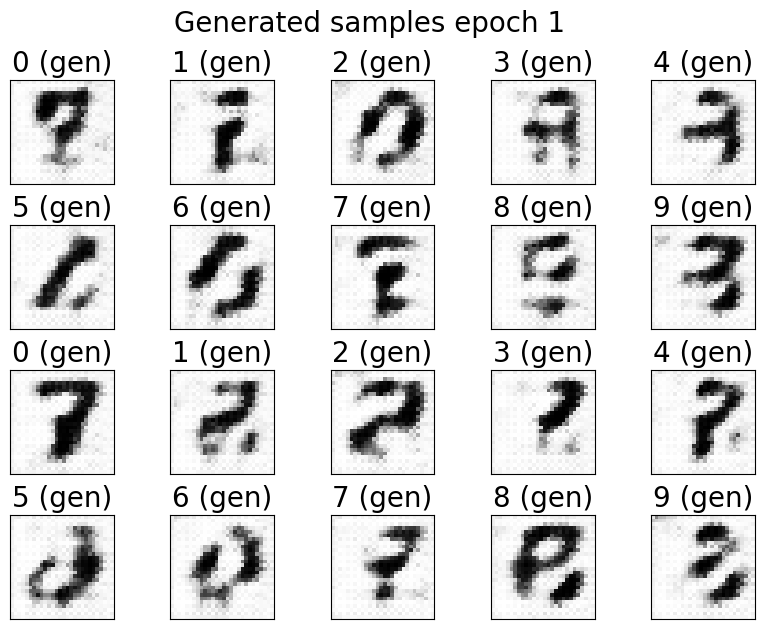

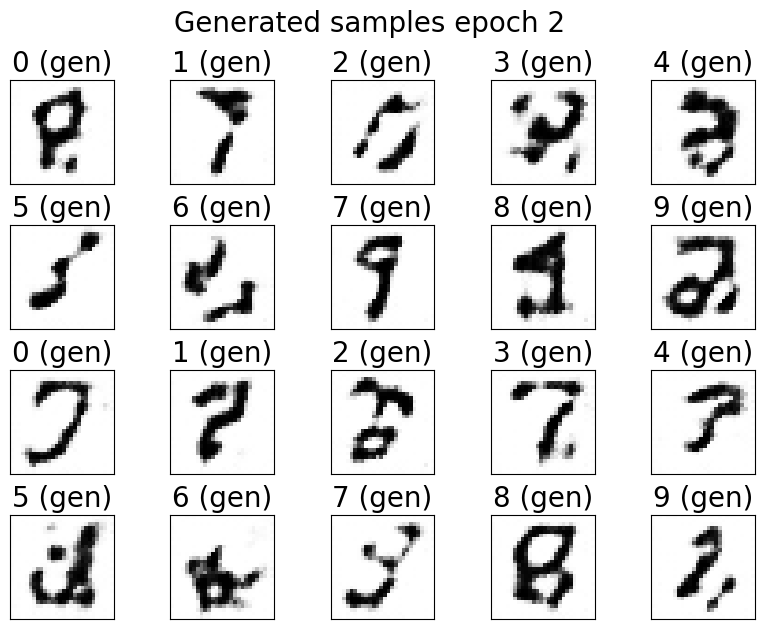

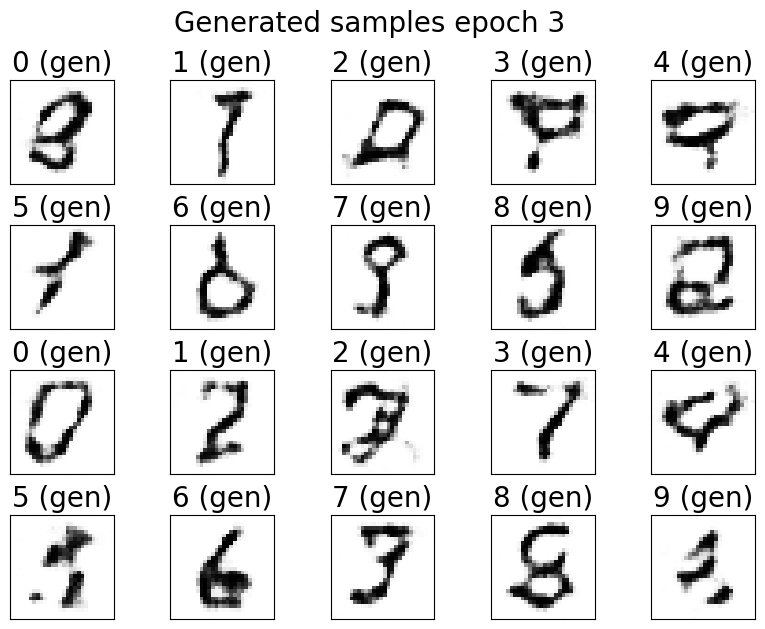

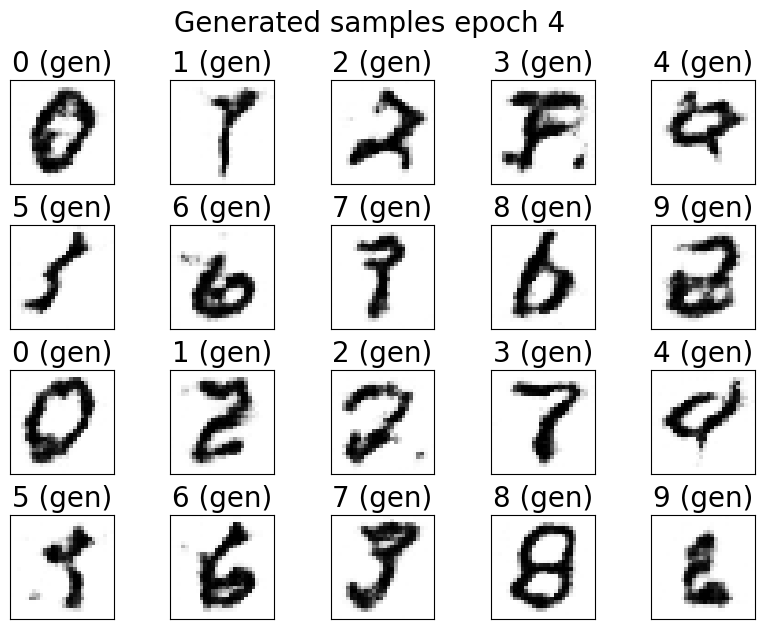

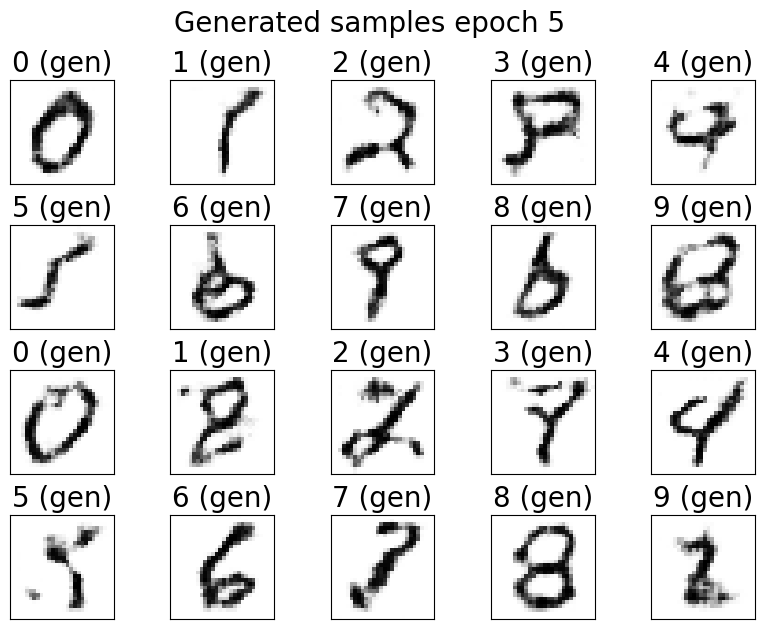

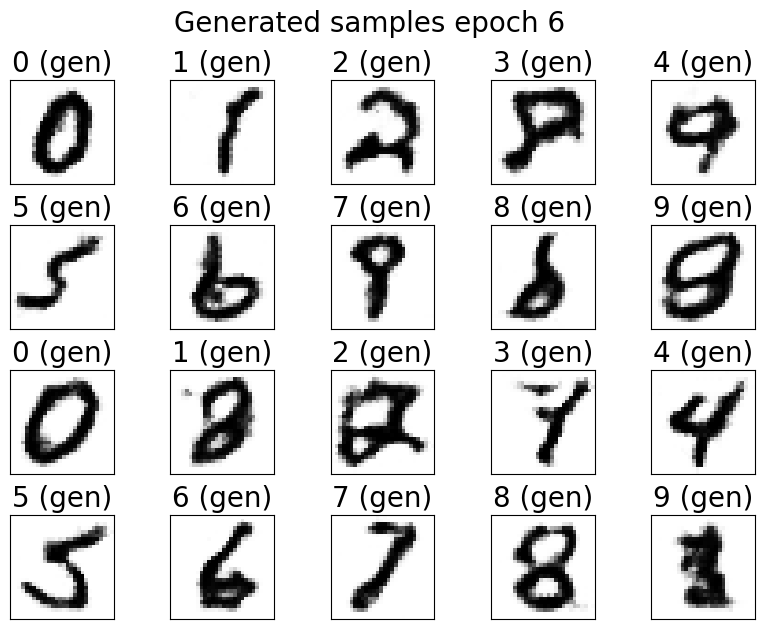

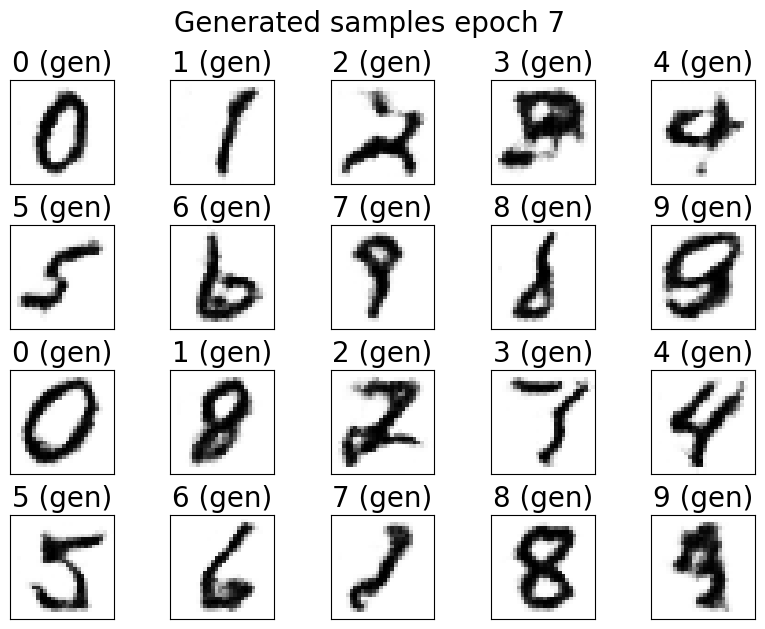

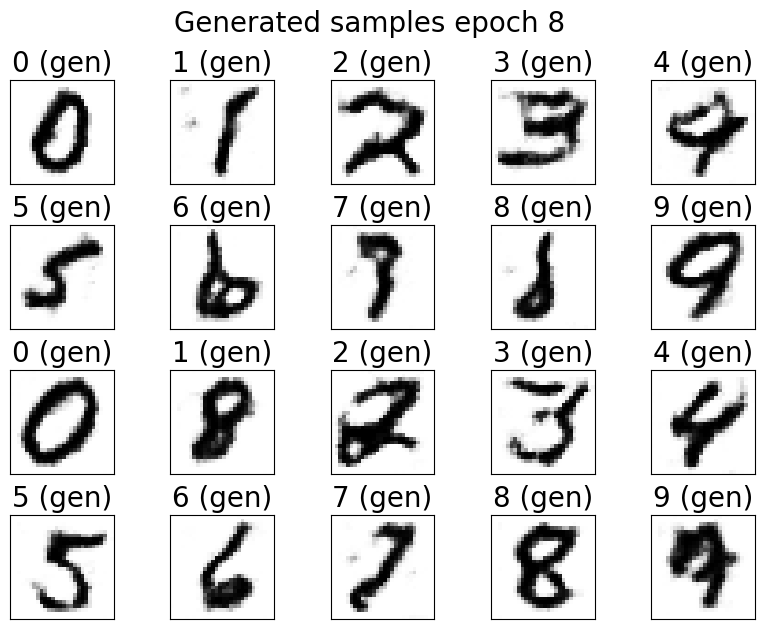

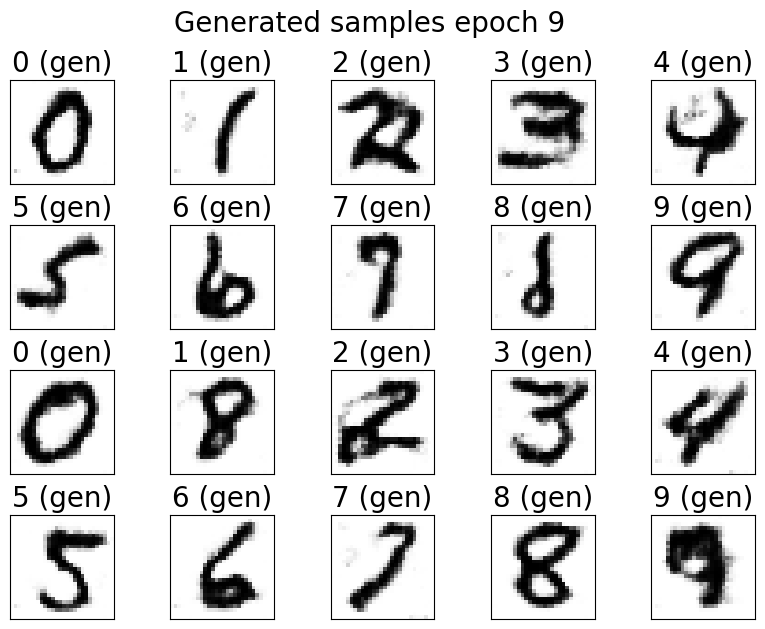

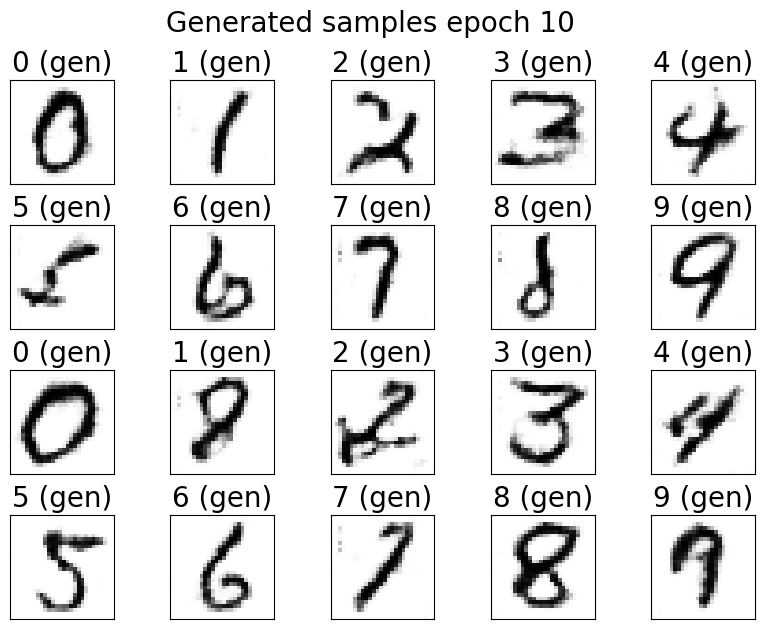

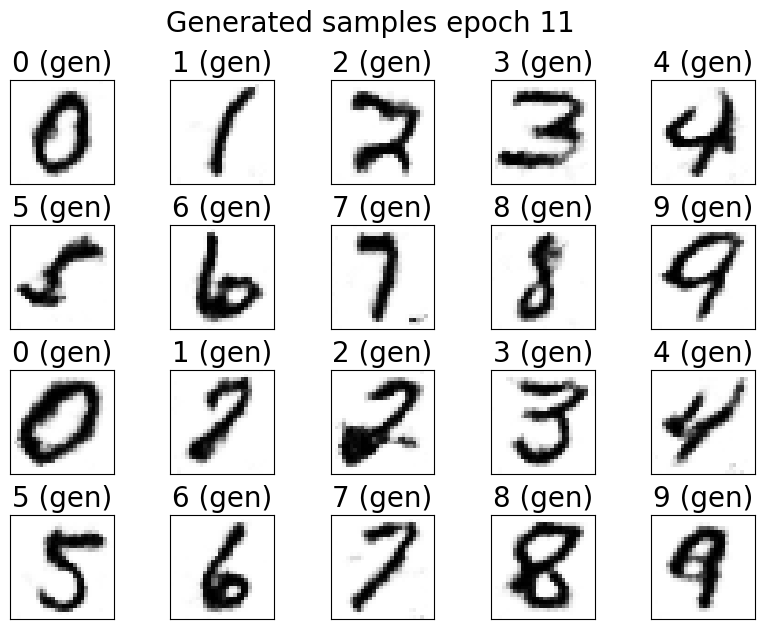

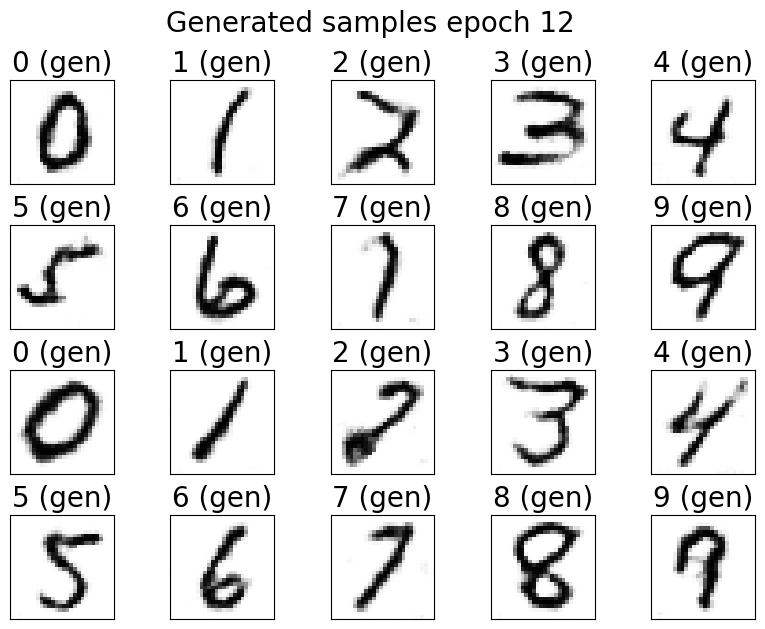

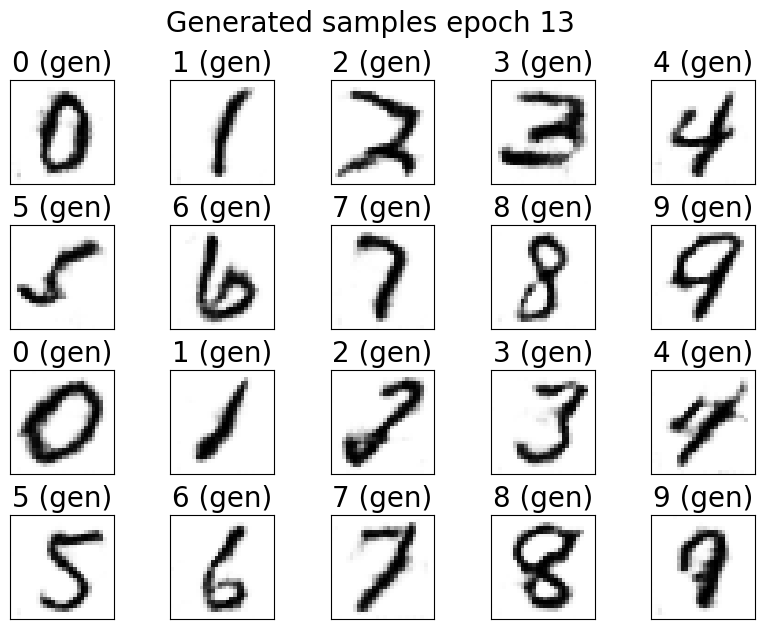

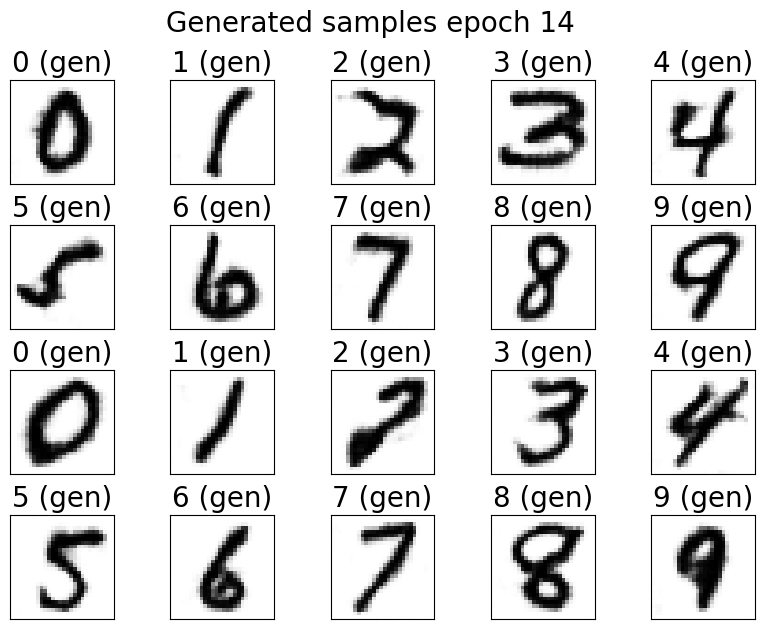

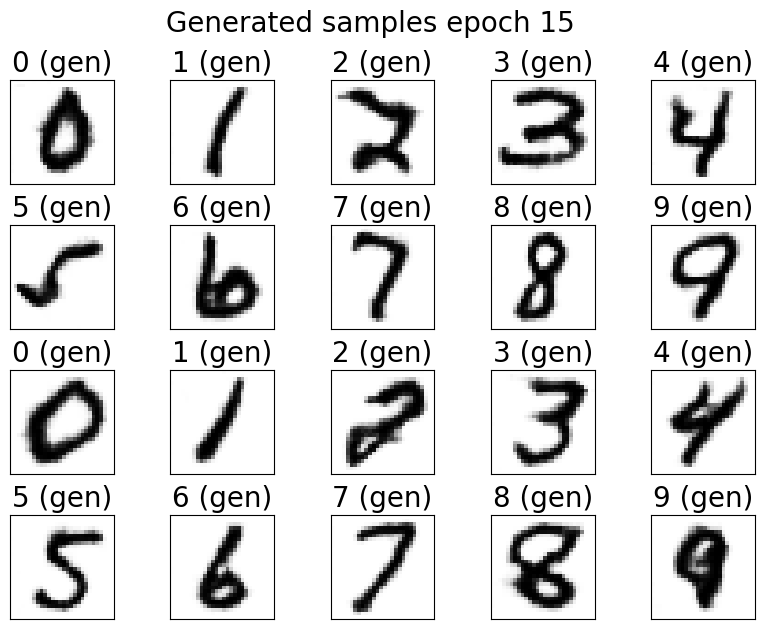

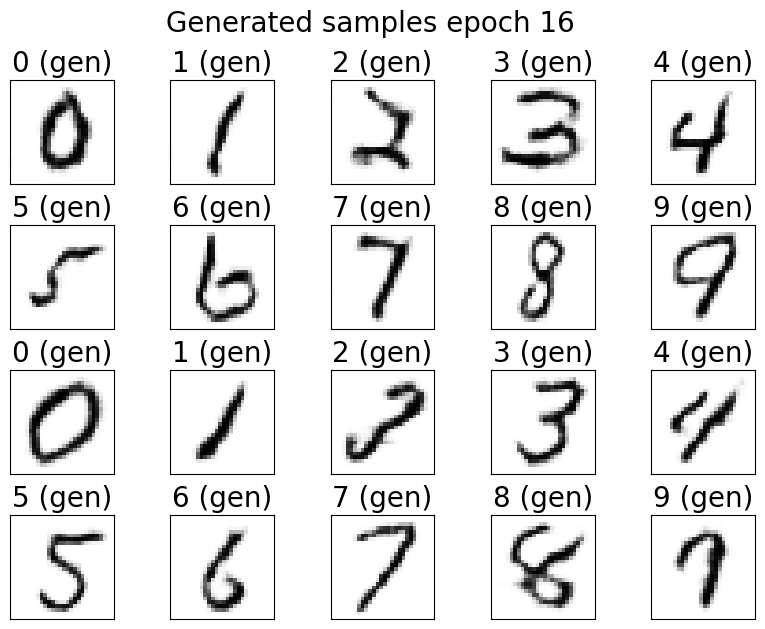

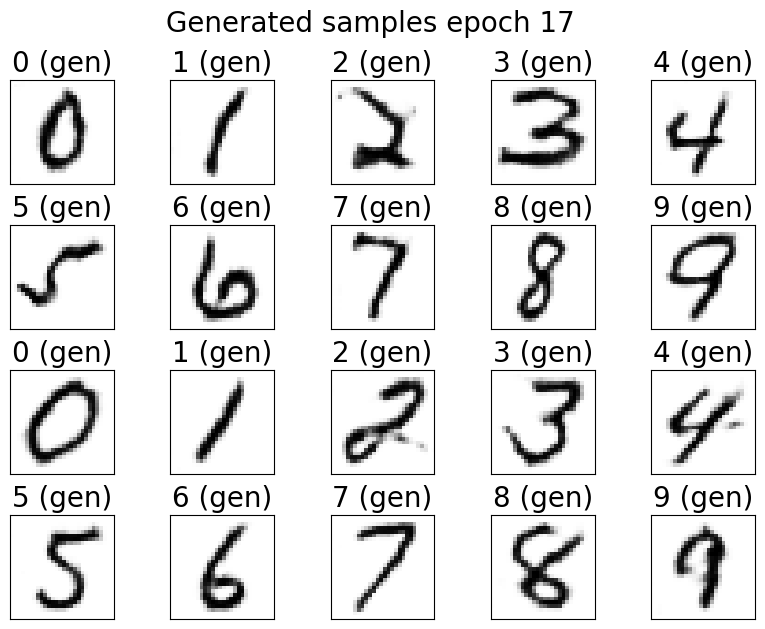

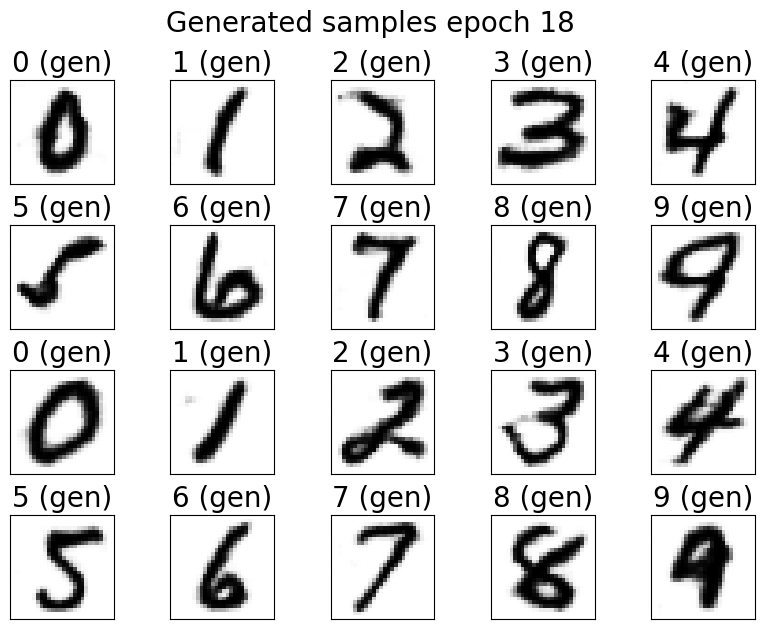

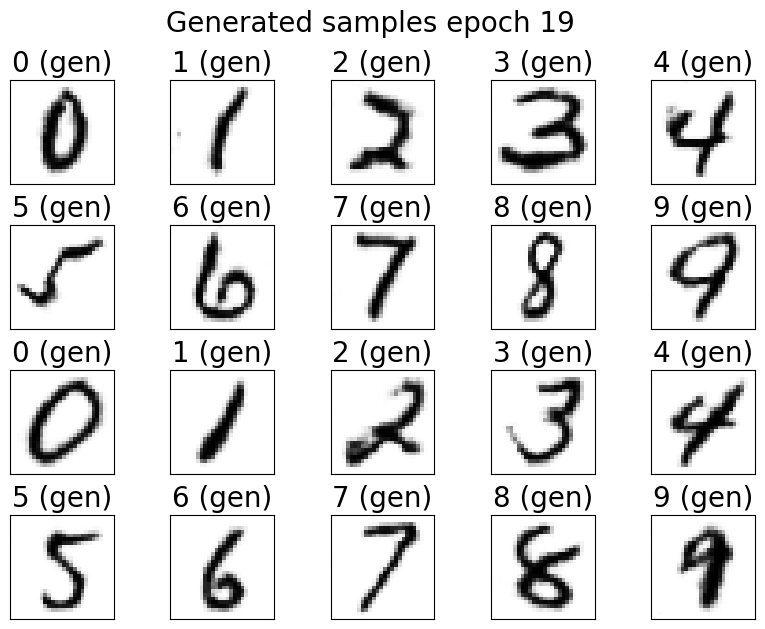

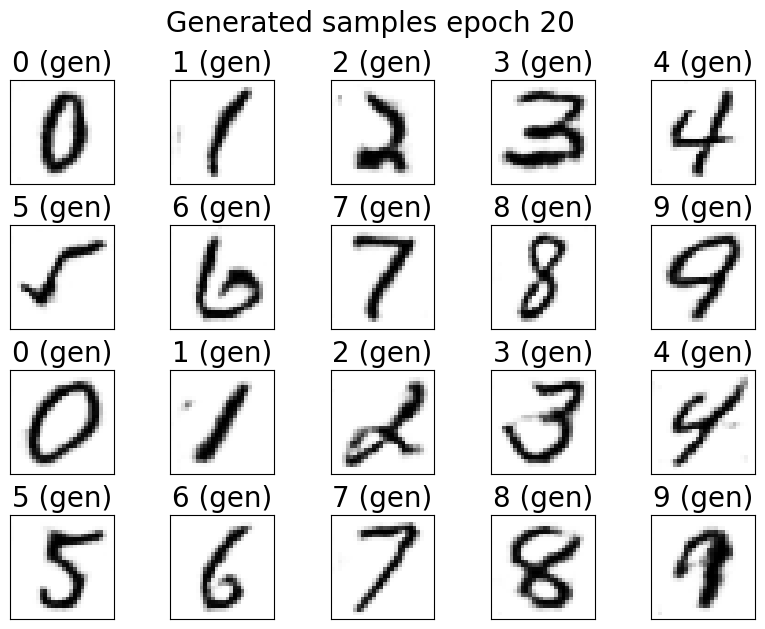

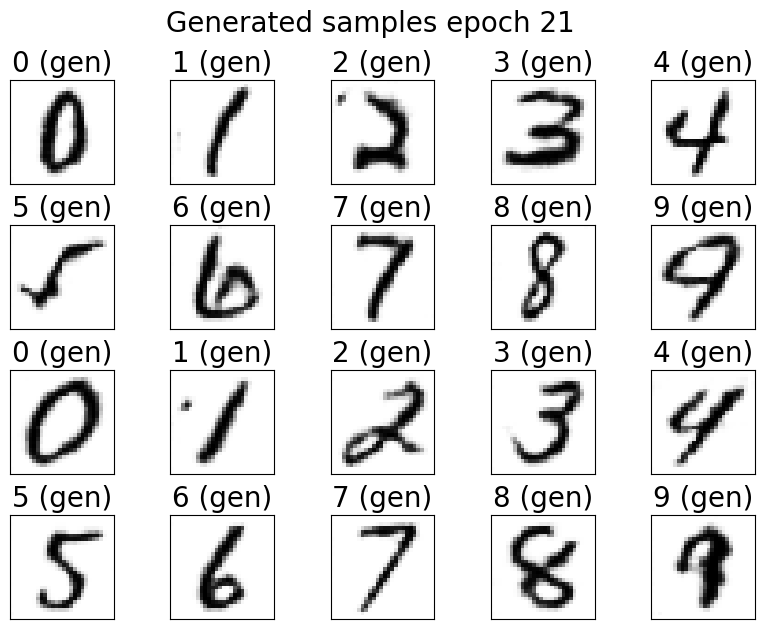

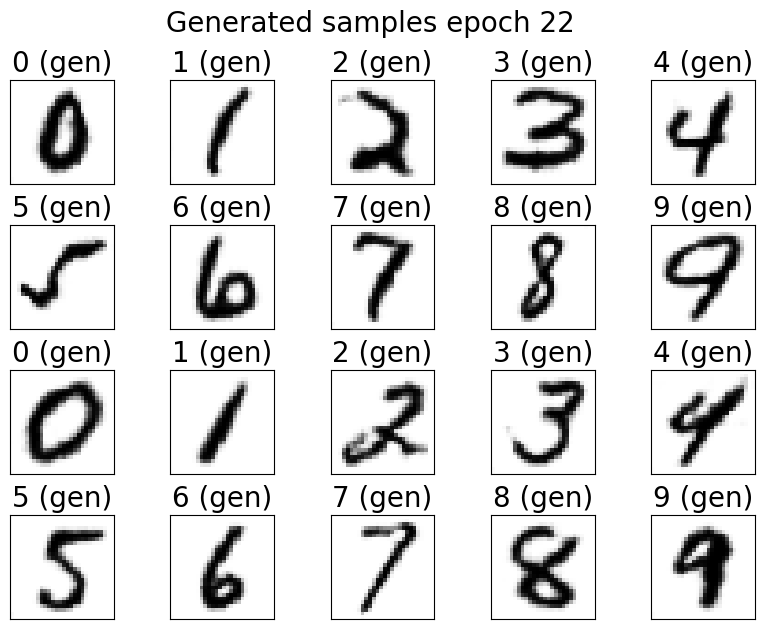

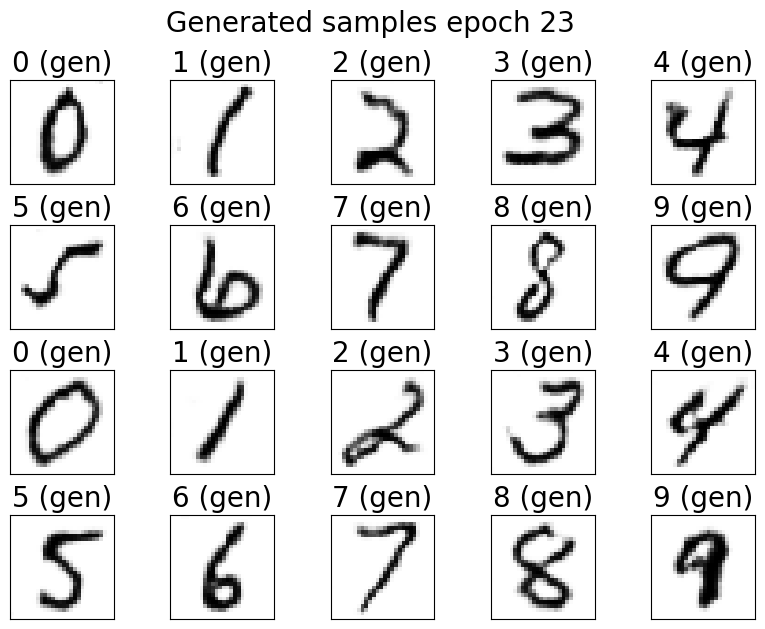

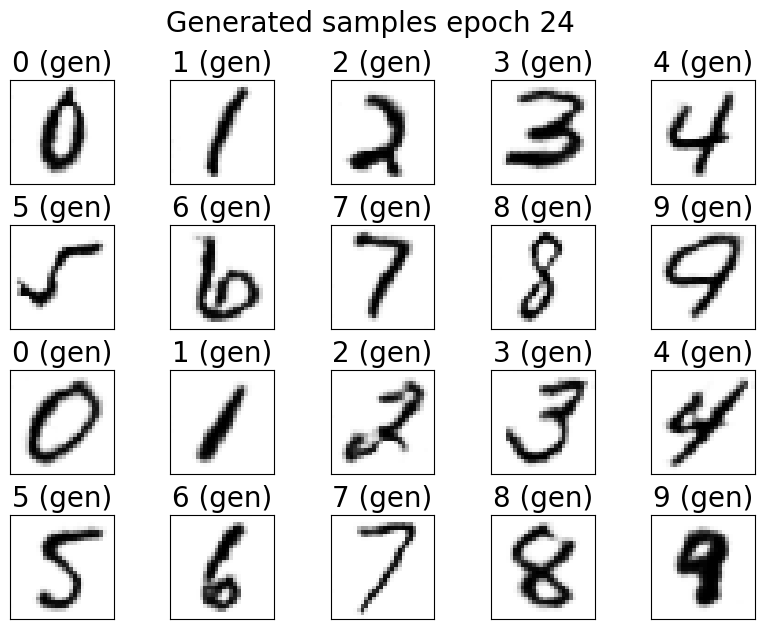

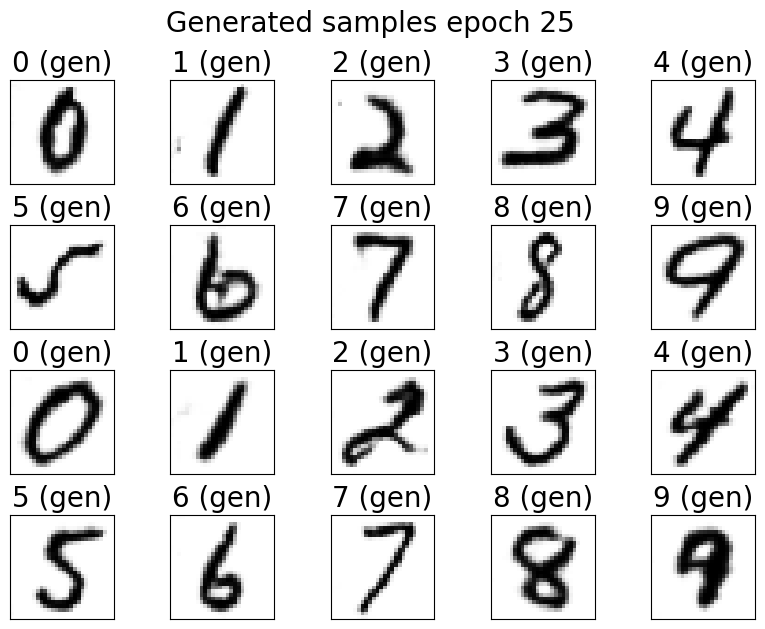

In [ ]:
##### Training of the GAN

time_start = time.time()
n_seen_data = 0
print("Training starts")

for epoch in range(1,num_epochs+1):
    time_start_epoch = time.time()
    print("EPOCH", epoch)

    disc_tot = 0
    gen_tot = 0

    for batch, data in enumerate(train_loader):

        discriminator.train()
        generator.eval()

        # Data for training the discriminator (2*batch_size in total: batch_size true + batch_size fake)
        all_samples, all_samples_labels, all_samples_numbers = createDiscriminatorData(data, generator, dim_latent_space, device)

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_samples_numbers)
        loss_d = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator[epoch,batch] = loss_d
        predictions = discriminator.predict(output_discriminator)
        accuracy_train[epoch, batch] = computeGANAccuracy(predictions, all_samples_labels)

        # Don't train discriminator at each batch: train the discriminator every generator_advantage batch
        if torch.rand(1)*max(generator_advantage,1.0) < 1.0:
            loss_d.backward()
            optimizer_discriminator.step()
            disc_tot += 1

        discriminator.eval()
        generator.train()

        # Data (from latent space) for training the generator (2*batch_size in total: batch_size*2 fake)
        latent_space_samples, generated_samples_numbers, generated_samples_labels = createGeneratorData(batch_size*2, dim_latent_space, generator.n_classes, device, training='generator')

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples, generated_samples_numbers)
        output_discriminator_generated = discriminator(generated_samples['image'], generated_samples_numbers)
        # Top-k training: we train the generator only with its k best generated samples (we choose k=batch_size//3)
        k_output_discriminator_generated, k_indices = torch.topk(output_discriminator_generated, k, dim=0, sorted=False)
        loss_g = loss_function(k_output_discriminator_generated, generated_samples_labels[k_indices])
        loss_generator[epoch,batch] = loss_g

        if torch.rand(1)*max(discriminator_advantage,1.0) < 1.0:
            loss_g.backward()
            optimizer_generator.step()
            gen_tot += 1

        n_seen_data += len(data)

    # Show loss training
    printGANLoss(loss_discriminator, loss_generator, epoch)

    discriminator.eval()
    generator.eval()

    # Compute accuracy on test set
    for batch, data in enumerate(test_loader):

        all_samples, all_samples_labels, all_samples_numbers = createDiscriminatorData(data, generator, dim_latent_space, device)
        output_discriminator = discriminator(all_samples, all_samples_numbers)
        predictions = discriminator.predict(output_discriminator)
        accuracy_test[epoch, batch] = computeGANAccuracy(predictions, all_samples_labels)

    # Show accuracy (train + test sets)
    printGANAccuracy(accuracy_train, accuracy_test, epoch)

    # Check generated images
    if epoch % max(1,(num_epochs//15)) == 0:
        generated_samples = generator(reference_latent_space_samples, reference_number_samples)
        plotSamples(generated_samples, epoch=epoch, source=source)

    time_end_epoch = time.time()
    time_epoch = computeAndPrintTime("Time epoch", epoch, time_start_epoch, time_end_epoch)

time_end = time.time()
time_training = computeAndPrintTime("Total training time epochs", epoch, time_start, time_end)
mean_time_epoch = time_training/num_epochs

### Plot the results
You should plot the evolution of your error metrics (accuracy and loss function) in function of the number of epochs, to see how efficient the training is.

In [32]:
def plotGANLoss(loss_discriminator_stats, loss_generator_stats, num_epochs, source="."):
    plt.close("Loss")
    plt.figure("Loss", figsize = (20,15))
    plt.title("Loss during training", fontsize=30)
    plt.grid()
    epochs = np.arange(num_epochs+1)
    plt.plot(epochs, loss_discriminator_stats[0], label = "Discriminator")
    plt.fill_between(epochs, loss_discriminator_stats[0]-loss_discriminator_stats[1], loss_discriminator_stats[0]+loss_discriminator_stats[1], alpha = 0.3)
    plt.plot(epochs, loss_generator_stats[0], label = "Generator")
    plt.fill_between(epochs, loss_generator_stats[0]-loss_generator_stats[1], loss_generator_stats[0]+loss_generator_stats[1], alpha = 0.3)
    plt.legend(fontsize=30)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.ylim(bottom=0.0)
    plt.tick_params(axis = 'both', which = 'both',labelsize = 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    plt.savefig(source + '/Figures/Loss__' + now + '__' + str(num_epochs) + '_epochs.png')
    plt.show()
    return

def plotGANAccuracy(accuracy_train_stats, accuracy_test_stats, num_epochs, source="."):
    plt.close("Accuracy")
    plt.figure("Accuracy", figsize = (20,15))
    plt.title("Accuracy of discriminator", fontsize=30)
    plt.grid()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    epochs = np.arange(num_epochs+1)
    plt.plot(epochs, accuracy_train_stats[0][:,0], label = "Train", color=colors[0], linestyle='-')
    plt.fill_between(epochs, accuracy_train_stats[0][:,0]-accuracy_train_stats[1][:,0], accuracy_train_stats[0][:,0]+accuracy_train_stats[1][:,0], alpha = 0.3, color=colors[0])
    plt.plot(epochs, accuracy_train_stats[0][:,1], label = "Train real", color=colors[0], linestyle='--')
    plt.plot(epochs, accuracy_train_stats[0][:,2], label = "Train fake", color=colors[0], linestyle=':')
    plt.plot(epochs, accuracy_test_stats[0][:,0], label = "Test", color=colors[1], linestyle='-')
    plt.fill_between(epochs, accuracy_test_stats[0][:,0]-accuracy_test_stats[1][:,0], accuracy_test_stats[0][:,0]+accuracy_test_stats[1][:,0], alpha = 0.3, color=colors[1])
    plt.plot(epochs, accuracy_test_stats[0][:,1], label = "Test real", color=colors[1], linestyle='--')
    plt.plot(epochs, accuracy_test_stats[0][:,2], label = "Test fake", color=colors[1], linestyle=':')
    plt.legend(fontsize=30)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.ylim(0.0,1.0)
    plt.axhline(y=0.5, color='darkgray', linestyle='--', label='Random classifier')
    plt.tick_params(axis = 'both', which = 'both',labelsize = 30)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    plt.savefig(source + '/Figures/Accuracy__' + now + '__' + str(num_epochs) + '_epochs.png')
    plt.show()
    return

### 1.c Error metrics for the training

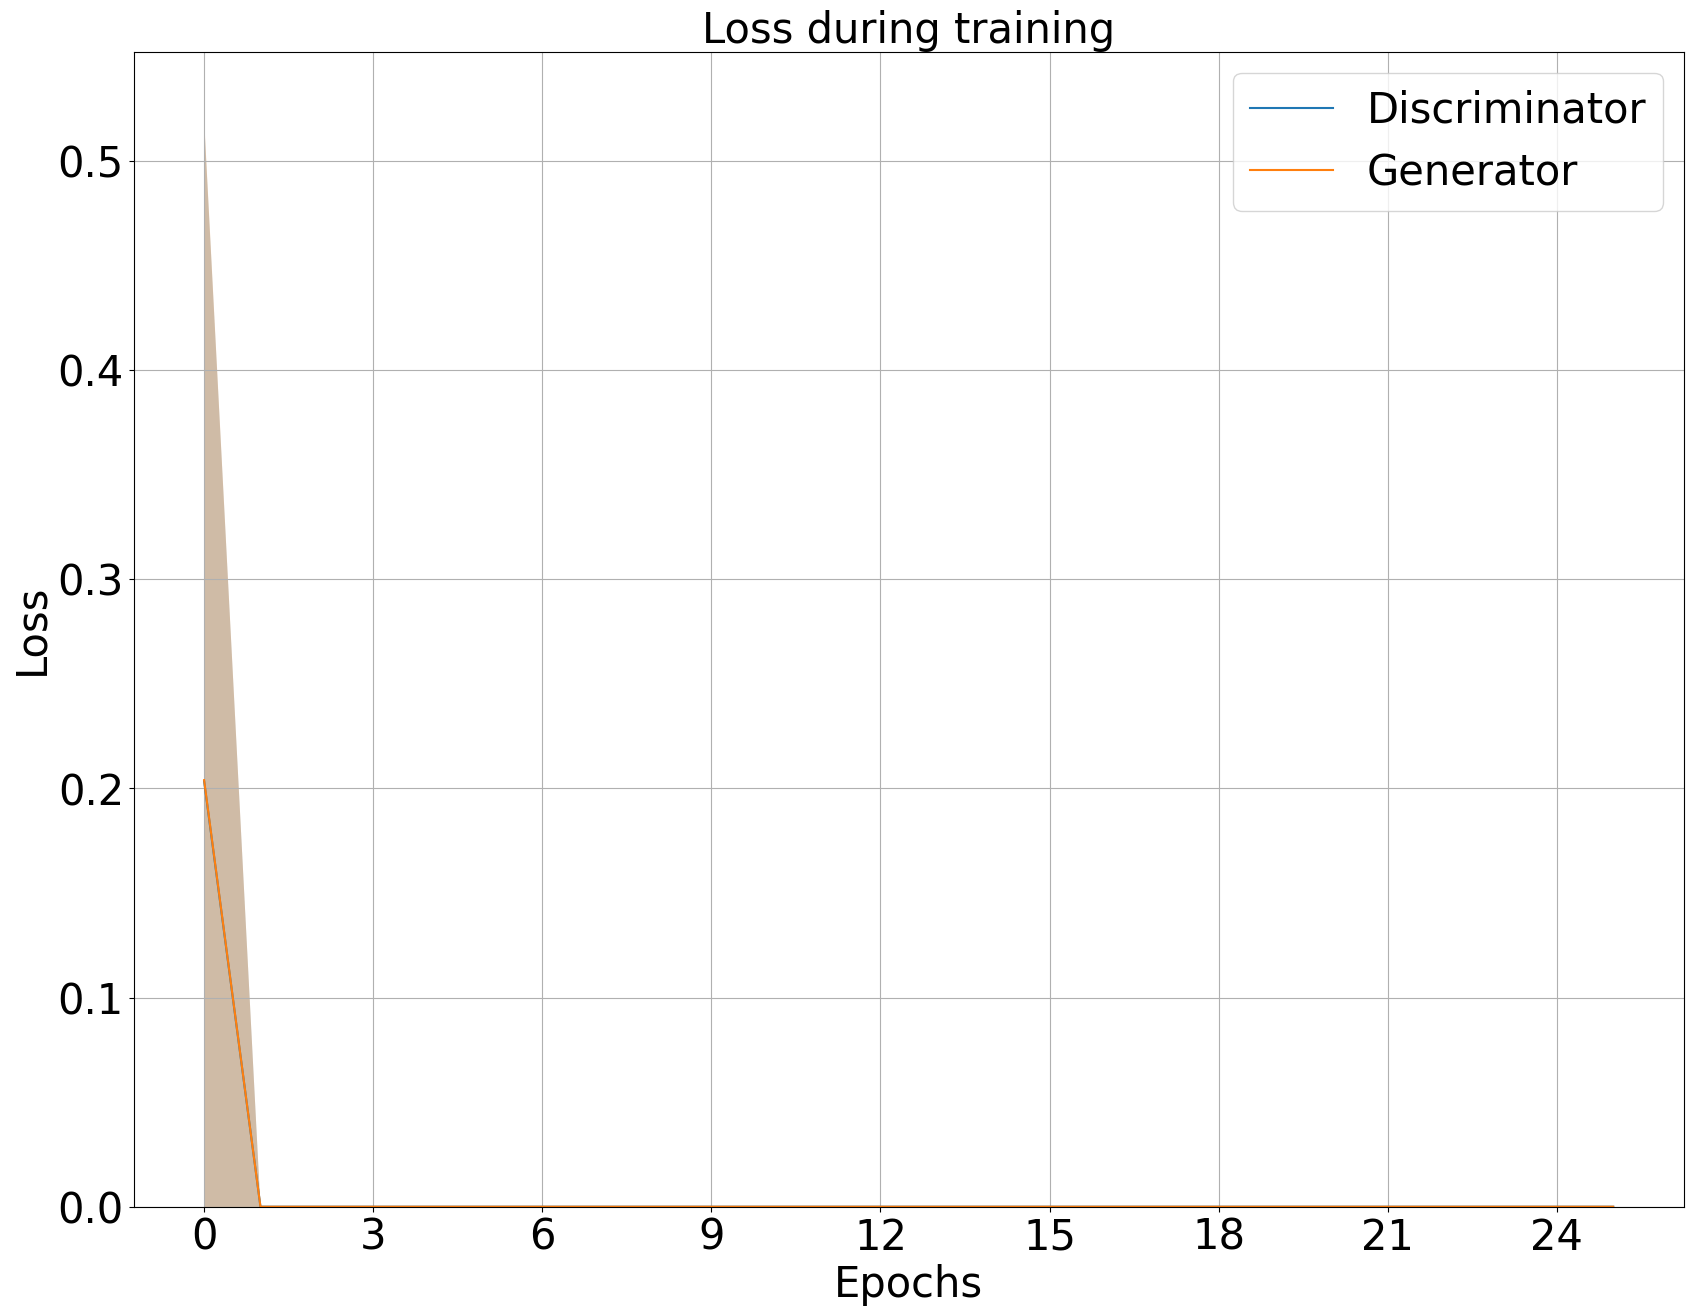

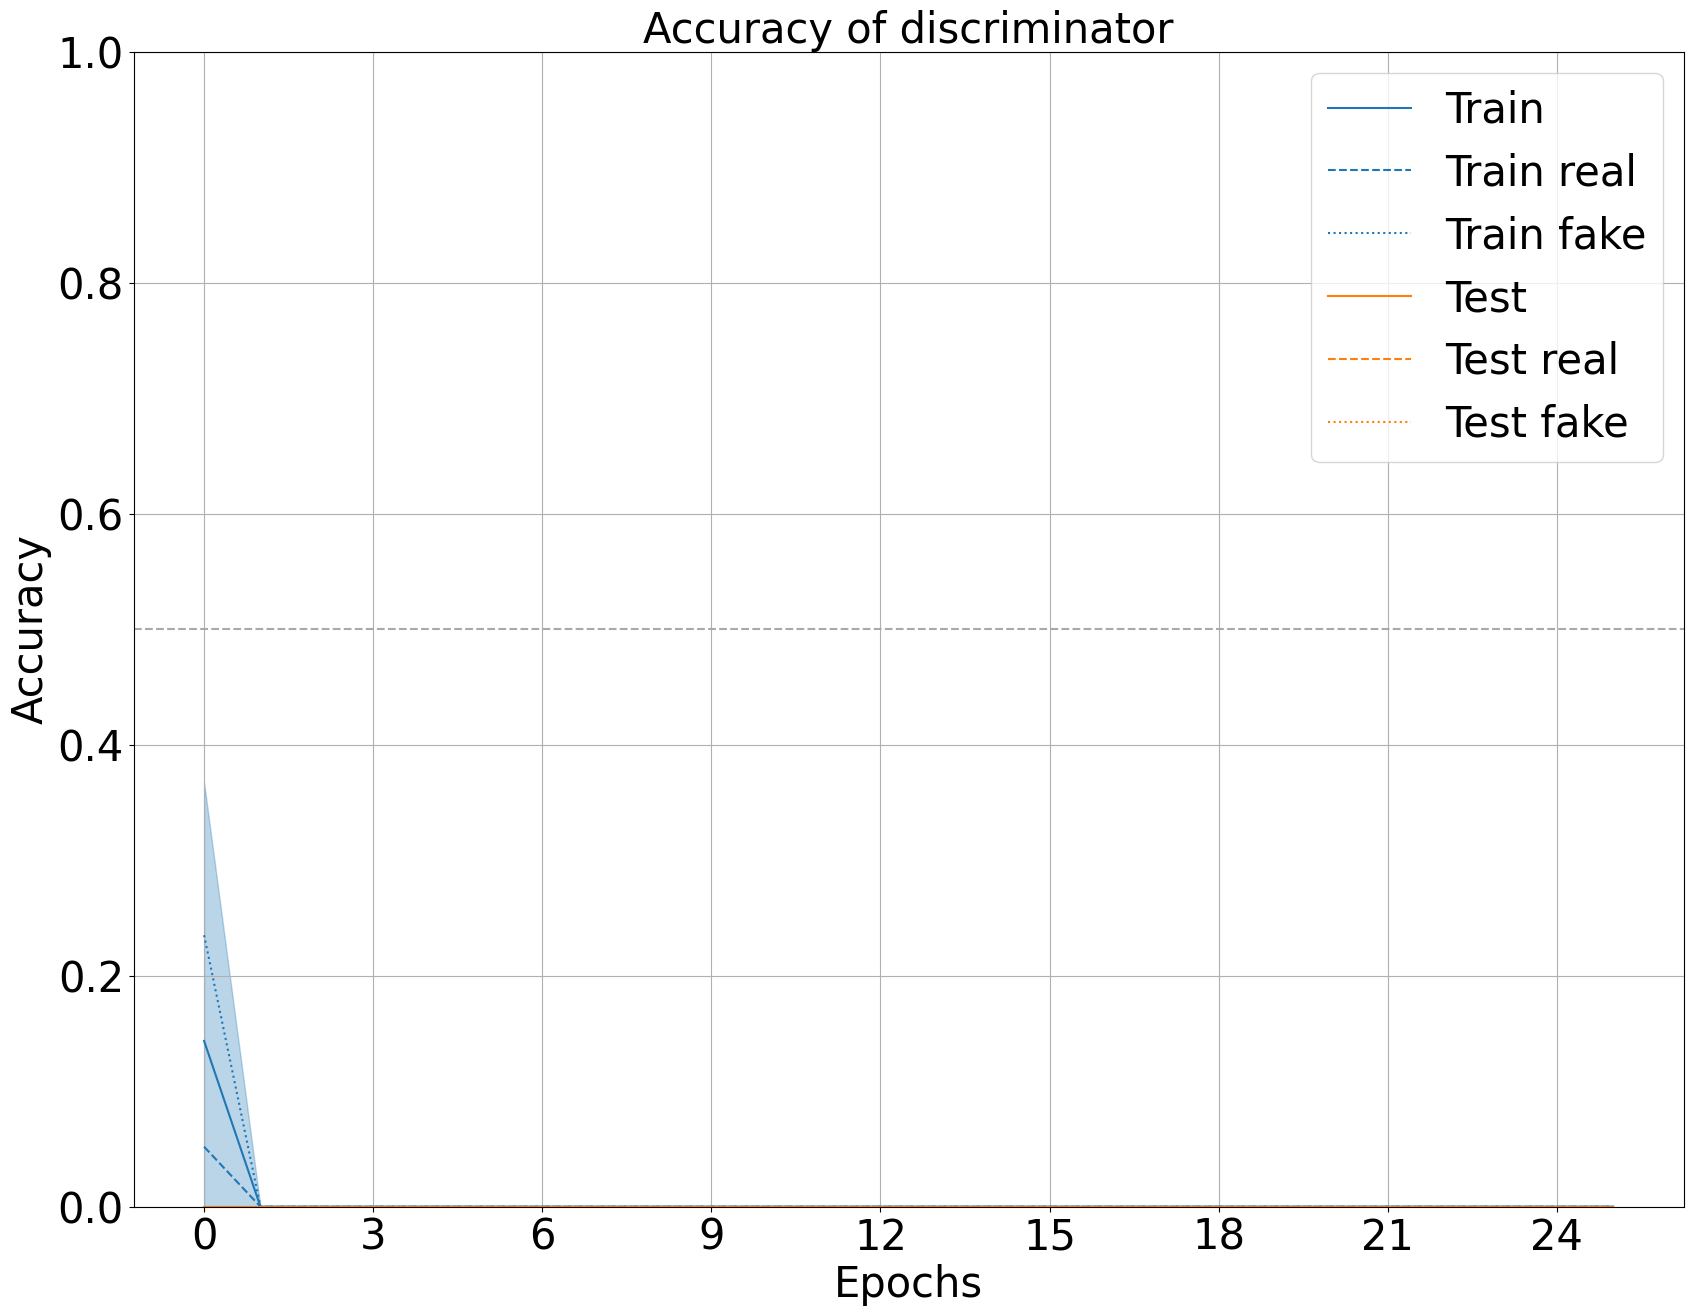

In [37]:
loss_discriminator_stats = (np.mean(loss_discriminator, axis = 1), np.std(loss_discriminator, axis = 1))
loss_generator_stats = (np.mean(loss_generator, axis = 1), np.std(loss_generator, axis = 1))
accuracy_train_stats = (np.mean(accuracy_train, axis = 1), np.std(accuracy_train, axis = 1))
accuracy_test_stats = (np.mean(accuracy_test, axis = 1), np.std(accuracy_test, axis = 1))

plotGANLoss(loss_discriminator_stats, loss_generator_stats, num_epochs, source=source)
plotGANAccuracy(accuracy_train_stats, accuracy_test_stats, num_epochs, source=source)

### Save your models
A really useful feature for your experiments is to be able to save your models. This can be done with the torch.save function. In the function saveModel, a model is stored in the folder ./Models that you may want to create (or any other folder if defined otherwise above). The (date)time is used to always store your models with a different name and never lose some training that you would have done.

Be careful however: the saveModel function below stores the "state dictionary" of your model, not your model itself.

You can of course modify the function saveModel as you wish.

In [ ]:
def saveModel(model, model_name, source='.'):
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    torch.save(model.state_dict(), source + '/Models/' + model_name + '__' + now)

#### Example
#
# D = Discriminator().to(device)
# saveModel(D, "Discriminator")
#
##
# The model D has been saved as "Discriminator__2022_11_12__15_21" in the folder Models as your code finished running at
# 15:21 on the 12 November 2022.
##

In [ ]:
##### Save discriminator and generator

saveModel(discriminator, 'Discriminator', source=source)
saveModel(generator, 'Generator', source=source)

### Load your models
You can also load models that you trained and saved earlier with the function loadModel.

However, be careful. You will have to first recreate a new instance of your class, and then import the state dictionary in the new instance. This means that the characteristics of your class should not have changed since then. In particular, the number of layers and the size of the layers need to match between the trained model and the most recent class in order to correctly assign the stored parameters. Moreover, there could be some trouble if you changed functions/methods from the class.

You can of course modify the function loadModel as you wish.

In [33]:
def loadModel(model, model_name, date_time, device="cpu", source='.'):
    model.load_state_dict(torch.load(source + '/Models/' + model_name + '__' + date_time, map_location=device))
    model.eval()
    return model

#### Example
#
# D = Discriminator().to(device)
# loadModel(D, "Discriminator", "2022_11_12__15_21")
#
##
# The model "Discriminator__2022_11_12__15_21" from the folder Models has been loaded in the Discriminator D
##

## Section 2: Analyse your CGAN

You made it half-way through! This second part is dedicated to the analysis of some features of your trained GAN. Let's first load a particular save of your neural networks. Change the name of the file to load the models you want (i.e. change the datetime).

In [34]:
##### Load discriminator and generator

discriminator = Discriminator(dim_label_encoding, dataset.classes, ndf, image_resize).to(device)
generator = Generator(dim_latent_space, dim_label_encoding, dataset.classes, ngf, image_resize).to(device)

name=None     # TO COMPLETE
loadModel(discriminator, 'Discriminator', "2024_10_18__16_08_00", source=source, device=device)
loadModel(generator, 'Generator', "2024_10_18__16_08_01", source=source, device=device)

discriminator_info = getInfoModel(discriminator, batch_size, model_name = "discriminator")
generator_info = getInfoModel(generator, batch_size, model_name = "generator")

# Make sure that your model is fixed for testing

discriminator.eval()
generator.eval()

<ipython-input-33-81f97852edbd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(source + '/Models/' + model_name + '__' + date_time, map_lo

[(64, 1, 28, 28), (64,)]
Model: discriminator
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
Discriminator                            [64, 1, 28, 28]           [64]                      --                        --
├─Embedding: 1-1                         [64]                      [64, 3]                   30                        --
├─Linear: 1-2                            [64, 3]                   [64, 784]                 3,136                     --
├─Conv2d: 1-3                            [64, 2, 28, 28]           [64, 32, 14, 14]          608                       [3, 3]
├─LeakyReLU: 1-4                         [64, 32, 14, 14]          [64, 32, 14, 14]          --                        --
├─Dropout2d: 1-5                         [64, 32, 14, 14]          [64, 32, 14, 14]          --                        --
├─Conv2d: 1-6                            [64, 32, 14, 14]          [64, 64, 14, 14]   

Generator(
  (emb0): Embedding(10, 3)
  (lin1): Linear(in_features=53, out_features=3136, bias=True)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (trans_conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (trans_conv4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (trans_conv5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (tanh5): Tanh()
)

You have now to analyze your latent space by yourself. To help you, don't hesitate to use every method that you defined in your Discriminator and Generator as well as all the other functions given in the Notebook.

In [35]:
# Show one representative of each class

latent_space_samples = generateLatentVectors(5*dataset.n_classes, dim_latent_space, device=device)
all_samples_numbers = torch.IntTensor([0]*5+[1]*5+[2]*5+[3]*5+[4]*5+[5]*5+[6]*5+[7]*5+[8]*5+[9]*5)
emb = generator.labelToEmbedding(all_samples_numbers)

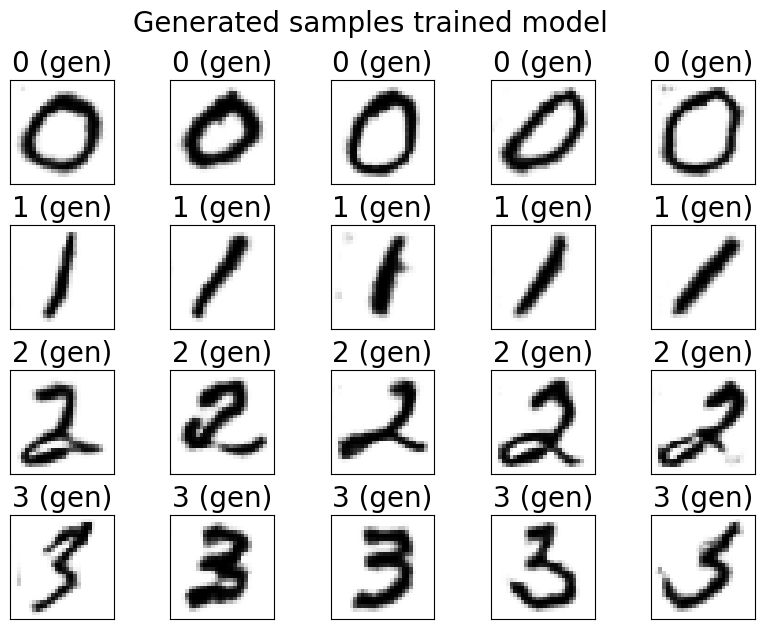

In [36]:
generated_samples_bis = generator(latent_space_samples[:20], emb[:20], device)
plotSamples(generated_samples_bis, epoch=None, source=source)

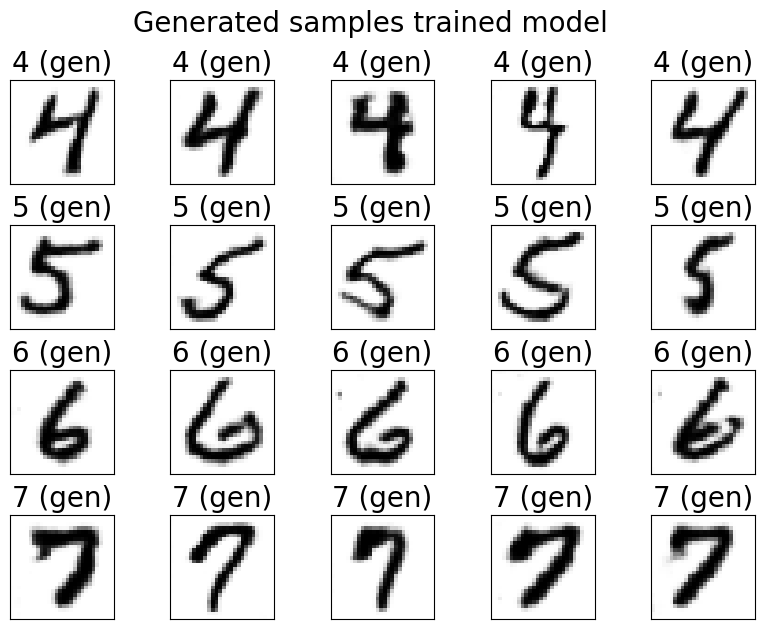

In [37]:
generated_samples_bis = generator(latent_space_samples[20:40], emb[20:40], device)
plotSamples(generated_samples_bis, epoch=None, source=source)

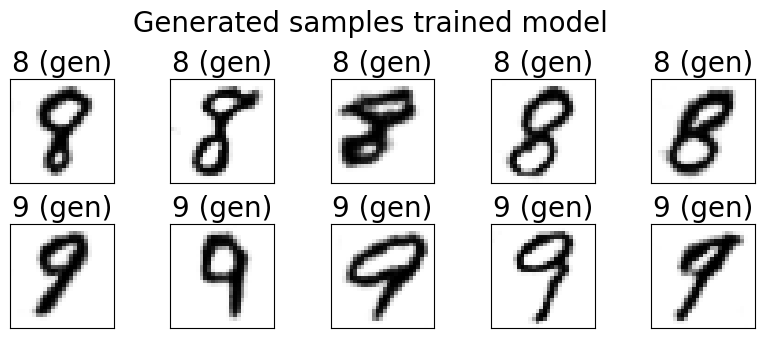

In [38]:
generated_samples_bis = generator(latent_space_samples[40:], emb[40:], device)
plotSamples(generated_samples_bis, epoch=None, source=source)

### 2.1 Diversity in each class


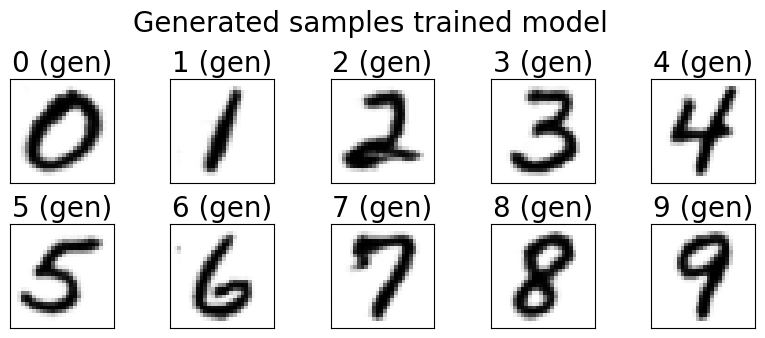

In [39]:
# Diversity in one class

# TO COMPLETE
# Using zero vector as latent sample
emb = generator.labelToEmbedding(torch.IntTensor([0,1,2,3,4,5,6,7,8,9]))
latent_space_samples = torch.zeros((dataset.n_classes,dim_latent_space)).to(device)
generated_samples_bis = generator(latent_space_samples, emb, device)
plotSamples(generated_samples_bis, epoch=None, source=source)

### 2.2 Discrimination in each class

In [40]:
# Discriminate within one class

# TO COMPLETE
size = 500
true_label = []
predicted_label = []
numbers = []

for n in range(size):
  dataset_image = train_dataset[np.random.randint(0,len(train_dataset))]["image"]
  number = train_dataset[np.random.randint(0,len(train_dataset))]["number"]
  numbers += [number,number]

  lat = generateLatentVectors(1,dim_latent_space)
  emb = generator.labelToEmbedding(torch.IntTensor([number]))

  gen = generator(lat,emb,device)

  gen_pred = discriminator.scalingOutputs(discriminator.forward(gen["image"],torch.IntTensor([number])))
  sample_pred = discriminator.scalingOutputs(discriminator.forward(torch.unsqueeze(dataset_image,0),torch.IntTensor([number])))

  true_label += ["Fake","Real"]
  # Prediction for generated image
  if gen_pred>0.5:
    predicted_label += ["Real"]
  else:
    predicted_label += ["Fake"]

  # Prediction for real image
  if sample_pred>0.5:
    predicted_label += ["Real"]
  else:
    predicted_label += ["Fake"]

# Accuracy in each class
for nbr in range(10):
  subset = np.array(numbers) == nbr
  accuracy = np.sum((np.array(predicted_label)==np.array(true_label))[subset])/np.sum(subset)
  print(f"Class:{nbr} Accuracy: {accuracy}")

# Predictions for "Real"
real_predictions = np.sum(np.array(predicted_label) == "Real")/(2*size)
print(f"Percentage of real predictions:{real_predictions}")

# Number of false positives (positive = "Real" predicted)
subset_real = np.array(predicted_label)=="Real"
n_FP = np.sum(np.array(true_label)[subset_real] == "Fake")
print("Number of false positives: ",n_FP)

# Number of false negatives (negative = "Fake" predicted)
subset_fake = np.array(predicted_label)=="Fake"
n_FN = np.sum(np.array(true_label)[subset_fake] == "Real")
print("Number of false negatives: ",n_FN)

Class:0 Accuracy: 0.717391304347826
Class:1 Accuracy: 0.6547619047619048
Class:2 Accuracy: 0.7169811320754716
Class:3 Accuracy: 0.635593220338983
Class:4 Accuracy: 0.6307692307692307
Class:5 Accuracy: 0.55
Class:6 Accuracy: 0.7105263157894737
Class:7 Accuracy: 0.7127659574468085
Class:8 Accuracy: 0.6090909090909091
Class:9 Accuracy: 0.6111111111111112
Percentage of real predictions:0.167
Number of false positives:  5
Number of false negatives:  338


### 2.3 Outside of distribution

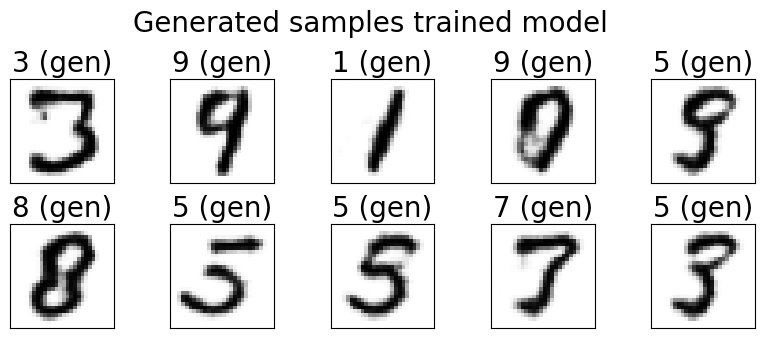

In [41]:
# Random embedding vectors


# TO COMPLETE
rand_emb = generateLatentVectors(dataset.n_classes,dim_label_encoding,device=device)
generated_samples_out = generator(latent_space_samples, rand_emb, device)
plotSamples(generated_samples_out, epoch=None, source=source)

### 2.4 Interpolation for exploration

In [42]:
def interpolate(start_tensor, end_tensor, device, n_steps=10):
    interpolating_tensor = start_tensor + torch.outer(torch.linspace(0,1,n_steps).to(device), end_tensor-start_tensor)
    return interpolating_tensor

In [43]:
# 4
ELV1 = torch.Tensor([-8.1296e-01, -6.2418e-01, -4.3574e-02,  4.1509e-01, -1.0562e+00,
        -1.3110e+00,  6.5309e-01,  2.0459e+00,  2.2429e-01, -3.7641e-01,
         3.7821e-01,  5.6240e-01,  1.7017e+00,  9.5350e-01, -1.3951e+00,
        -1.7345e-01, -4.3304e-01, -1.0321e-01,  2.4623e+00, -3.8487e-01,
         3.0735e-01, -8.8135e-01, -2.7291e-01, -1.0016e+00, -4.4883e-01,
         1.0369e+00,  1.2118e+00, -2.1390e+00, -4.9329e-01,  1.8246e+00,
         3.9297e-01,  9.3315e-01, -1.4359e-01,  1.3082e+00, -3.7575e-01,
         2.4998e-01, -8.5773e-01,  3.4037e-01, -1.9515e-01, -1.1523e+00,
        -1.4561e+00, -3.0615e-02,  6.7820e-01,  1.5367e-03,  2.4144e+00,
         1.7740e-02, -1.1718e+00,  1.1653e-01, -1.4483e-01,  6.2698e-01])
ELV2 = torch.Tensor([ 1.2870, -0.0647, -0.7524, -0.9264, -0.1913,  1.4750, -0.3498,  1.1556,
         1.0947,  1.0359,  1.8767,  0.1695,  0.5374,  1.1970, -0.2771,  0.0879,
        -0.4079,  0.7192, -1.4714,  0.5255, -0.4674, -0.1142,  0.3654, -0.7264,
        -0.6465, -1.0630,  0.1455, -0.8330,  0.6391,  0.1314, -0.6046, -0.0197,
        -0.2448,  1.5949,  0.5234, -1.0876,  1.2769, -0.7620, -0.9716, -1.3852,
         0.4414,  0.9691,  0.4059,  1.1280, -0.6759, -0.3114, -1.7737, -0.9597,
        -2.2936, -0.6181])

# 8
ELV3 = torch.Tensor([ 0.0470,  0.5737,  1.0494, -0.8593,  0.5924, -0.0596,  0.5602, -1.0822,
         1.3965,  0.9525, -1.3945,  1.5178,  0.6910, -0.3259, -0.9001,  0.1862,
        -0.1649, -0.8168,  0.1864,  0.6306,  0.5510,  0.7778,  0.0627, -0.0452,
        -0.4411,  1.6478,  1.3077, -0.6382,  1.1506, -2.6088,  1.4622,  0.9126,
         0.0998, -0.7520,  0.9512,  0.8556, -0.9729,  0.8687,  0.4720,  1.2994,
        -0.2136, -1.5948,  1.0092, -0.2833, -0.7381,  0.2173, -0.3107, -1.9369,
        -0.3615,  0.8298])

ELV4 = torch.Tensor([-0.3288,  1.4527,  0.8791, -0.2797,  0.7085,  0.0284,  1.1247,  1.1712,
        -1.7187,  0.8001, -0.6383,  1.3913, -0.6797,  0.2833, -0.7873, -0.4487,
         1.5961, -1.0050, -0.6744,  1.6878, -0.7355,  0.1593, -0.2611,  1.3960,
         1.1553, -1.1157,  1.5436, -2.0213,  1.2571,  1.5524,  0.3951, -0.0105,
         0.5439,  0.5104, -0.5224, -0.6671,  0.4749, -1.0728, -0.8755, -0.1546,
        -1.1049, -1.3468,  0.7101,  0.1073,  0.5162,  0.8003, -0.0567, -1.1859,
        -0.2094, -0.5358])

# 7
ELV5 = torch.Tensor([-1.1346, -1.7415,  0.1572, -0.0327, -0.7111, -0.4784,  1.7066,  1.1276,
        -0.1606,  1.2287,  0.0857,  0.3889, -0.3835,  0.1869,  0.0580,  0.9757,
         0.8401, -0.8921,  1.4640, -1.8677, -0.6856, -1.3181,  0.5315,  0.5285,
        -0.1441, -1.5908,  1.4426,  0.1876, -2.1367, -0.3697,  0.4027, -0.7607,
         1.3809, -0.3664,  1.2065, -0.2877,  0.8737, -1.3920, -0.0858, -0.3682,
         0.4344, -0.2317,  0.0554, -2.1364,  0.1604, -0.7462,  0.6610, -0.7031,
        -0.9152,  2.2398])

ELV6 = torch.Tensor([-1.6752, -2.6056, -0.3419,  2.2307,  0.1439,  0.5022,  2.1227,  0.0706,
        -0.0597,  2.2032,  0.3065, -0.5114,  1.8468, -1.5579, -0.7081,  0.6167,
         0.0041,  0.2015, -0.0934, -1.0610, -0.2671,  0.1114,  1.2305, -1.1154,
        -1.0878,  0.2251, -1.0821, -0.8570,  0.2810,  1.0984,  2.1827,  0.0789,
         0.9178, -1.0081,  0.0540,  0.9207,  0.9789,  0.0501,  0.4494,  0.5961,
        -1.3180,  0.9547, -0.3564, -1.6971, -0.0248, -2.2198, -0.2978, -1.0979,
         1.7094,  0.7985])

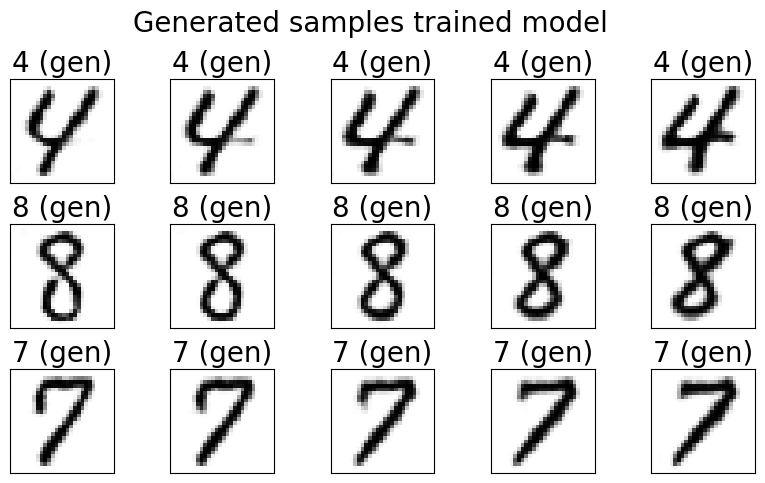

In [44]:
# Interpolate within a class

# TO COMPLETE
interp1 = interpolate(ELV1,ELV2,device,5)
embeds1 = generator.labelToEmbedding(torch.IntTensor([4]*5))

interp2 = interpolate(ELV3,ELV4,device,5)
embeds2 = generator.labelToEmbedding(torch.IntTensor([8]*5))

interp3 = interpolate(ELV5,ELV6,device,5)
embeds3 = generator.labelToEmbedding(torch.IntTensor([7]*5))


generated = generator(torch.cat((interp1,interp2,interp3)),torch.cat((embeds1,embeds2,embeds3)),device)
plotSamples(generated,epoch = None, source = source)

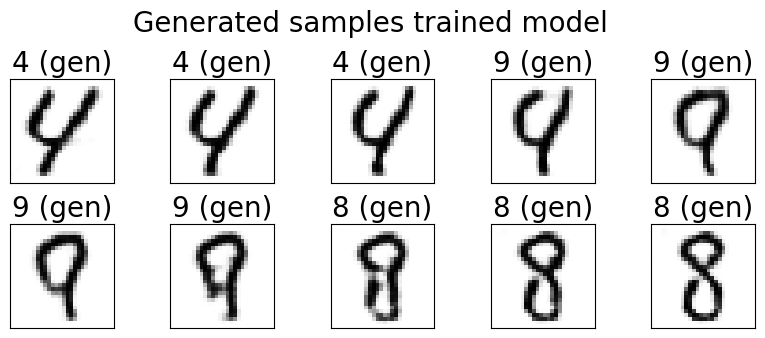

In [45]:
# Interpolate between two classes

# TO COMPLETE
ELV_4 = torch.Tensor([-8.1296e-01, -6.2418e-01, -4.3574e-02,  4.1509e-01, -1.0562e+00,
        -1.3110e+00,  6.5309e-01,  2.0459e+00,  2.2429e-01, -3.7641e-01,
         3.7821e-01,  5.6240e-01,  1.7017e+00,  9.5350e-01, -1.3951e+00,
        -1.7345e-01, -4.3304e-01, -1.0321e-01,  2.4623e+00, -3.8487e-01,
         3.0735e-01, -8.8135e-01, -2.7291e-01, -1.0016e+00, -4.4883e-01,
         1.0369e+00,  1.2118e+00, -2.1390e+00, -4.9329e-01,  1.8246e+00,
         3.9297e-01,  9.3315e-01, -1.4359e-01,  1.3082e+00, -3.7575e-01,
         2.4998e-01, -8.5773e-01,  3.4037e-01, -1.9515e-01, -1.1523e+00,
        -1.4561e+00, -3.0615e-02,  6.7820e-01,  1.5367e-03,  2.4144e+00,
         1.7740e-02, -1.1718e+00,  1.1653e-01, -1.4483e-01,  6.2698e-01])
ELV_8 = torch.Tensor([ 0.0470,  0.5737,  1.0494, -0.8593,  0.5924, -0.0596,  0.5602, -1.0822,
         1.3965,  0.9525, -1.3945,  1.5178,  0.6910, -0.3259, -0.9001,  0.1862,
        -0.1649, -0.8168,  0.1864,  0.6306,  0.5510,  0.7778,  0.0627, -0.0452,
        -0.4411,  1.6478,  1.3077, -0.6382,  1.1506, -2.6088,  1.4622,  0.9126,
         0.0998, -0.7520,  0.9512,  0.8556, -0.9729,  0.8687,  0.4720,  1.2994,
        -0.2136, -1.5948,  1.0092, -0.2833, -0.7381,  0.2173, -0.3107, -1.9369,
        -0.3615,  0.8298])
embed_4 = generator.labelToEmbedding(torch.IntTensor([4]))
embed_8 = generator.labelToEmbedding(torch.IntTensor([8]))

interp_lv = interpolate(ELV_4,ELV_8,device)
interp_embed = interpolate(embed_4[0],embed_8[0],device)

plotSamples(generator(interp_lv,interp_embed,device),epoch = None,source = source)

### 2.5 Noise for exploration

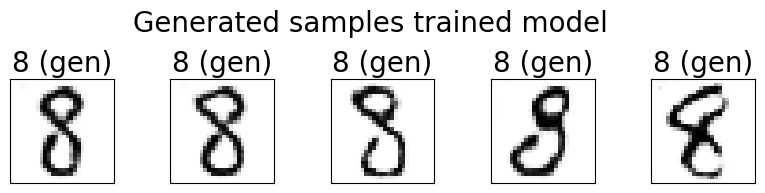

In [46]:
# Noise on latent vectors

# TO COMPLETE
latents = torch.Tensor([])
for sigma in [0.1,0.5,1.0,1.5,2]:
  noise = generateLatentVectors(1,dim_latent_space,scaling = sigma,device = device)
  latents = torch.cat((latents,ELV_8+noise))
embeds = generator.labelToEmbedding(torch.IntTensor([8]*5))
plotSamples(generator(latents,embeds,device),epoch = None,source=source)

In [47]:
# Noise on embedding vectors

# TO COMPLETE
embeds = torch.Tensor([])
embed8 = generator.labelToEmbedding(torch.IntTensor([8]))

unsqueezed = torch.unsqueeze(ELV_8,0)
latents = torch.Tensor([])
for sigma in [0.1,0.5,1.0,1.5,2]:
  noise = generateLatentVectors(1,dim_label_encoding,scaling = sigma,device = device)
  embeds = torch.cat((embeds,embed8+noise))
  latents = torch.cat((latents,unsqueezed))

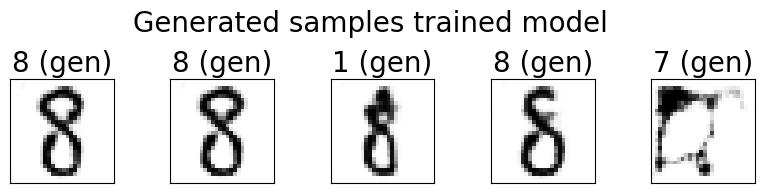

In [54]:
plotSamples(generator(latents,embeds,device),epoch = None,source = source)